# Class Workbook

## In class activity

We will load few libraries that will be used later on.

In [504]:
import numpy as np      # Numpy
import pandas as pd     # pandas
import math
from matplotlib.pyplot import subplots
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from plotnine import *
import plotly.express as px
import patchworklib as pw
#import statsmodels.api as sm
import statsmodels.formula.api as sm
#import ISLP as islp

### Ames Housing data

Please take a look at the Ames Hoursing data.

In [505]:
ames_raw=pd.read_csv("ames_raw.csv")

The goal of this exercise is to predict the price of the house.

Here is a histogram of the sales price with red line showing the mean. Notice that I am calling ggplot here from the plotnine library.  The sytax is almost identical, making it easy for R users.

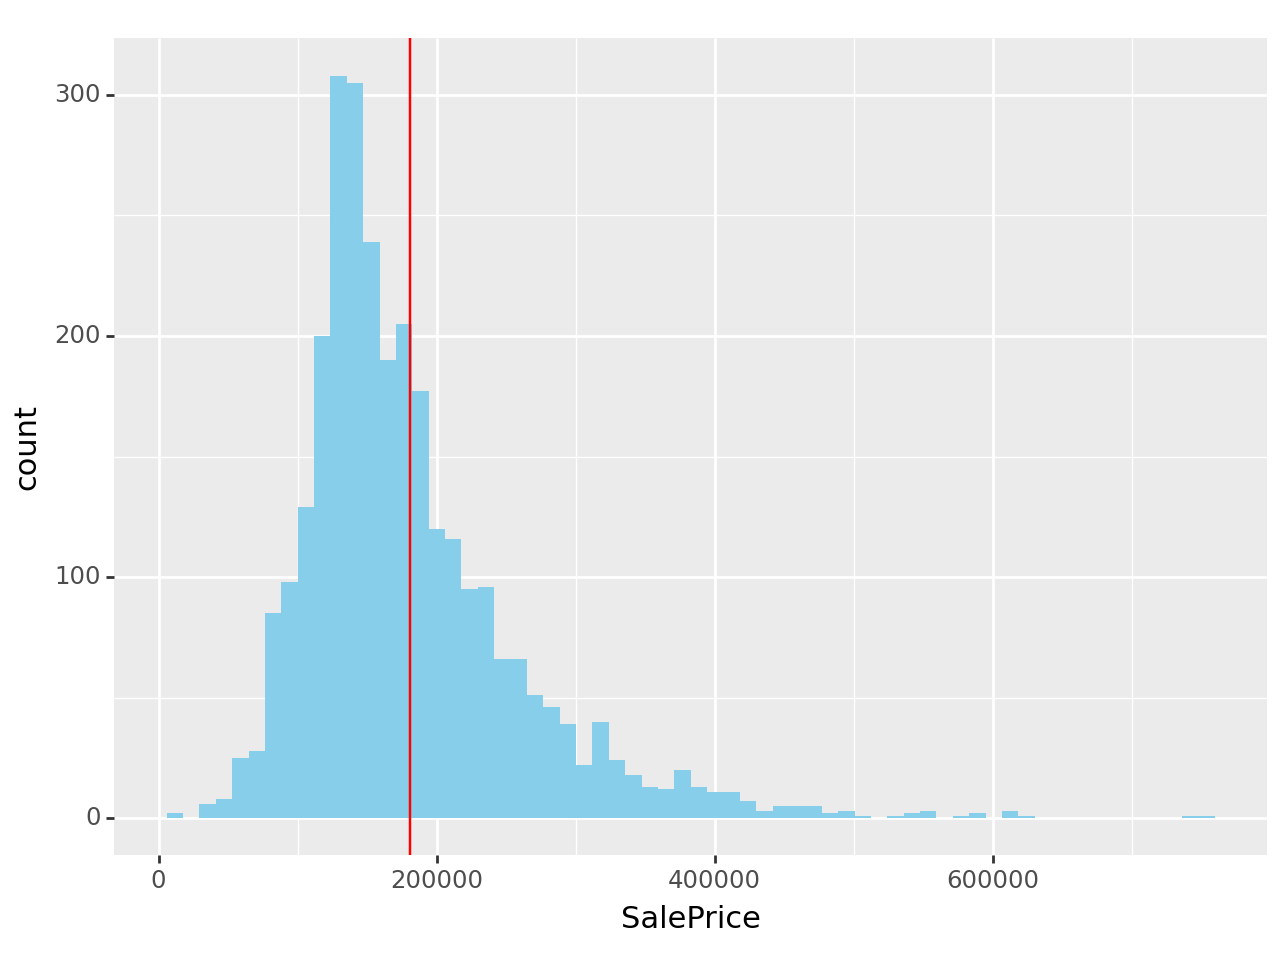

<Figure Size: (640 x 480)>

In [506]:
(
  ggplot(ames_raw)+geom_histogram(fill="skyblue")+aes(x="SalePrice")+
    geom_vline(xintercept = ames_raw.loc[:,"SalePrice"].mean(),colour="red")
)

Initial linear model without a predictor fit using ols function in statsmodels.formula.api.  The syntax for specifying the formula is again identical to R, which is nice.

In [507]:
y = 'SalePrice'
x = "1"
formula = '%s ~ %s' % (y, x)
lmfit_null = sm.ols(formula, data=ames_raw).fit()
print(lmfit_null.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Jan 2024   Prob (F-statistic):                nan
Time:                        16:48:41   Log-Likelihood:                -37232.
No. Observations:                2930   AIC:                         7.447e+04
Df Residuals:                    2929   BIC:                         7.447e+04
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1.808e+05   1475.845    122.503      0.0

How good is this result?  Let's look at RMSE.

In [508]:
pow(lmfit_null.resid.pow(2).mean(),1/2)

79873.05865192253

Since the price is right skewed lets log transformation the outcome

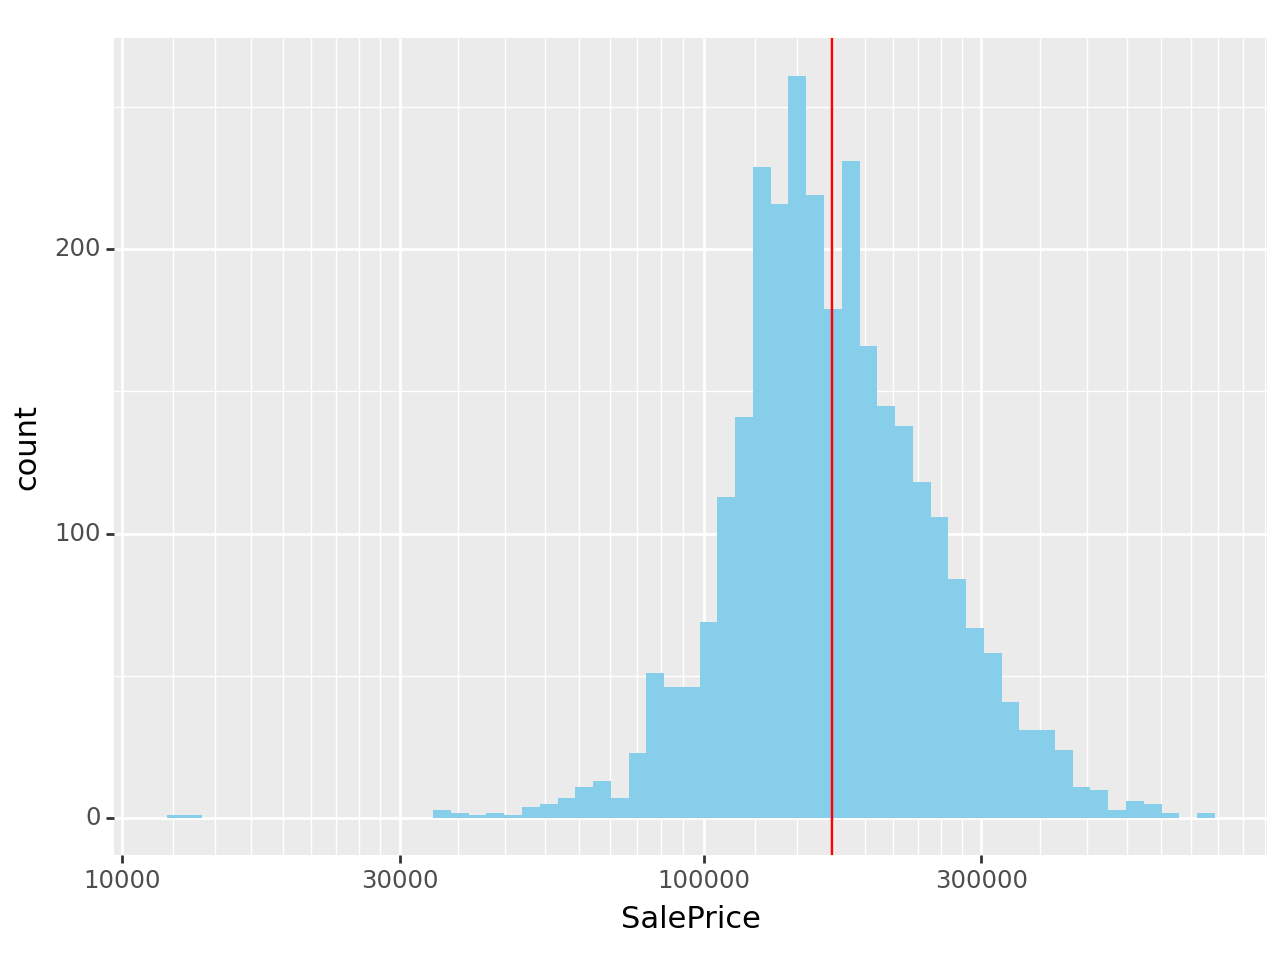

<Figure Size: (640 x 480)>

In [509]:
(
  ggplot(ames_raw)+geom_histogram(fill="skyblue")
  +aes(x="SalePrice")+geom_vline(xintercept =math.exp(np.log(ames_raw.loc[:,"SalePrice"]).mean()),colour="red")
  +scale_x_log10()
)

Fitting the same model on the log transformed outcome

In [510]:
ames_raw_temp=ames_raw.copy(deep=False)
ames_raw_temp.loc[:,"SalePrice"]=np.log(ames_raw_temp.loc[:,"SalePrice"])
y = 'SalePrice'
x = "1"
logformula = '%s ~ %s' % (y, x)
lmfit_null_log = sm.ols(logformula, data=ames_raw_temp).fit()
print(lmfit_null_log.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.000
Model:                            OLS   Adj. R-squared:                  0.000
Method:                 Least Squares   F-statistic:                       nan
Date:                Fri, 26 Jan 2024   Prob (F-statistic):                nan
Time:                        16:48:41   Log-Likelihood:                -1527.3
No. Observations:                2930   AIC:                             3057.
Df Residuals:                    2929   BIC:                             3063.
Df Model:                           0                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     12.0210      0.008   1596.442      0.0

RMSE is

In [511]:
logresid=ames_raw.loc[:,"SalePrice"]-np.exp(lmfit_null_log.predict())
pow(logresid.pow(2).mean(),1/2)

81195.11086340384

Notice that the RMSE is actually bigger with log transformed model.
So should we not transform?  What do we get from the transformation?

Here is the prediction uncertainty overlayed on the histogram.

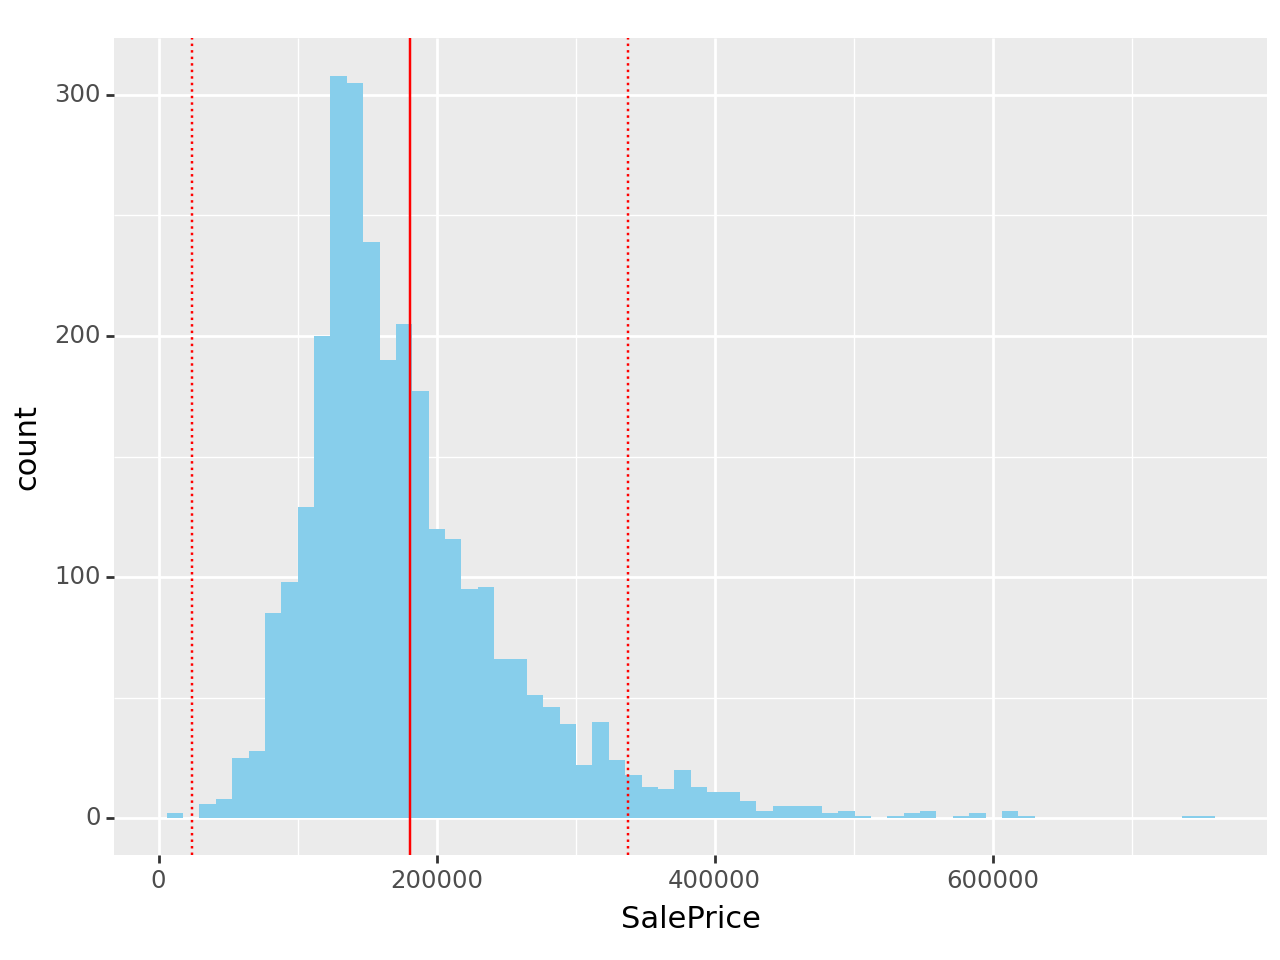

<Figure Size: (640 x 480)>

In [512]:
dt =lmfit_null.get_prediction(ames_raw.iloc[1,1:2]).summary_frame(alpha = 0.05)
y_prd = dt['mean']
yprd_ci_lower = dt['obs_ci_lower']
yprd_ci_upper = dt['obs_ci_upper']
(
  ggplot(ames_raw)+geom_histogram(fill="skyblue")
  +aes(x="SalePrice")
  +geom_vline(xintercept = y_prd,colour="red")
  +geom_vline(xintercept = yprd_ci_lower,colour="red",linetype="dotted")
  +geom_vline(xintercept = yprd_ci_upper,colour="red",linetype="dotted")
)

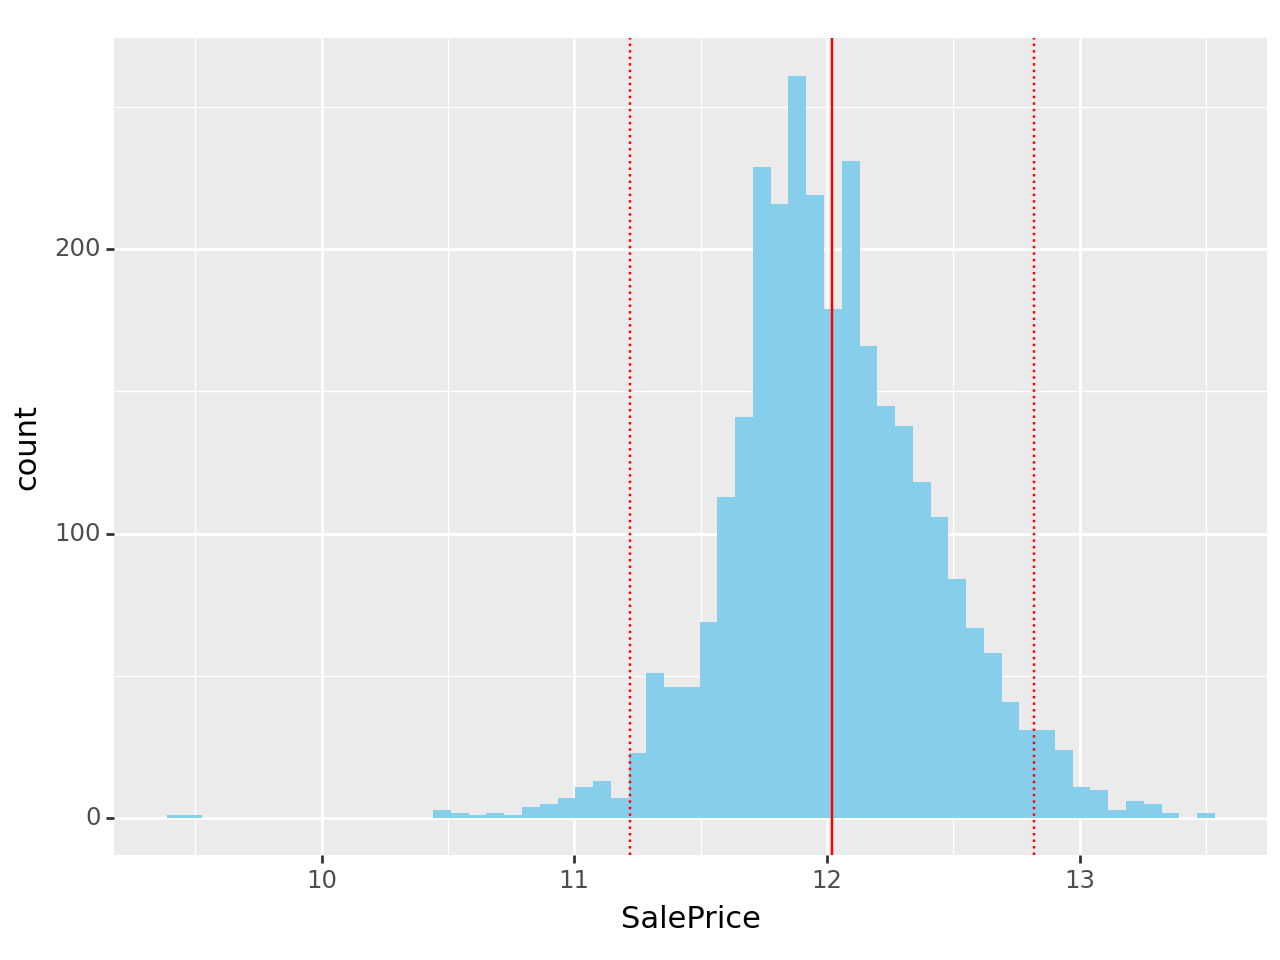

<Figure Size: (640 x 480)>

In [513]:
logdt =lmfit_null_log.get_prediction(ames_raw.iloc[1,1:2]).summary_frame(alpha = 0.05)
logy_prd = (logdt['mean'])
logyprd_ci_lower = (logdt['obs_ci_lower'])
logyprd_ci_upper = (logdt['obs_ci_upper'])

(
  ggplot(ames_raw_temp)+geom_histogram(fill="skyblue")
  +aes(x="SalePrice")
  +geom_vline(xintercept = logy_prd,colour="red")
  +geom_vline(xintercept = logyprd_ci_lower,colour="red",linetype="dotted")
  +geom_vline(xintercept = logyprd_ci_upper,colour="red",linetype="dotted")
)

The log model seem to have a better uncertainty estimate.  What good does that do?

Let’s say the model is for an algorithm that buys the house.  If you pay more than the true price the company buys. If the price is lower, then the company fails to buy.
- If you bought for more than the true value you’ve over paid.
- If you bid less and lost, you lost a profit of the 10% of the house price.

Based on such loss function what is our overall loss if we base our decision on this model?

In [514]:
allres=lmfit_null.resid
abs(sum(allres[allres<0]))+sum(0.1*(lmfit_null.params["Intercept"]+allres[allres>0]))

114215680.34334554

In [515]:
allreslog=ames_raw.loc[:,"SalePrice"]-np.exp(lmfit_null_log.predict(ames_raw_temp))
abs(sum(allreslog[allreslog<0]))+sum(0.1*(math.exp(lmfit_null_log.params["Intercept"])+allreslog[allreslog>0]))

94211654.66078955

As you can see with a better calibrated model you have a better performance for more realistic loss.

### Adding predictor `Gr Liv Area`

We add a predictor `Gr Liv Area`

In [516]:
fig = px.scatter(ames_raw, x="Gr Liv Area", y="SalePrice", marginal_x="histogram", marginal_y="histogram")
fig.show()

Using `Gr Liv Area` as predictor

In [517]:
lmfit_liv_area_0 = sm.ols("SalePrice ~ Q('Gr Liv Area')", data=ames_raw).fit()
lmfit_liv_area_1 = sm.ols("np.log(SalePrice)~Q('Gr Liv Area')", data=ames_raw).fit()
lmfit_liv_area_2 = sm.ols("np.log(SalePrice) ~np.log(Q('Gr Liv Area'))", data=ames_raw).fit()
print(lmfit_liv_area_0.summary())
print(lmfit_liv_area_1.summary())
print(lmfit_liv_area_2.summary())

                            OLS Regression Results                            
Dep. Variable:              SalePrice   R-squared:                       0.500
Model:                            OLS   Adj. R-squared:                  0.499
Method:                 Least Squares   F-statistic:                     2923.
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:48:42   Log-Likelihood:                -36218.
No. Observations:                2930   AIC:                         7.244e+04
Df Residuals:                    2928   BIC:                         7.245e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                       coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept         1.329e+04   3269.703  

In [518]:

g = (
ggplot(ames_raw)+geom_point()+aes(x="Gr Liv Area",y="SalePrice")
+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")
+geom_smooth(method="lm",se=False)
)
g1 = pw.load_ggplot(g, figsize=(4,4))

g = (
ggplot(ames_raw)+geom_point()+aes(x="Gr Liv Area",y="SalePrice")
+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=False)+scale_y_log10()
)
g2 = pw.load_ggplot(g, figsize=(4,4))

g = (
ggplot(ames_raw)+geom_point()+aes(x="Gr Liv Area",y="SalePrice")+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=False)+scale_y_log10()+scale_x_log10()
)
g3 = pw.load_ggplot(g, figsize=(4,4))

#knitr::include_graphics("./multiplots.png")

![fig](Images/multiplots.png)

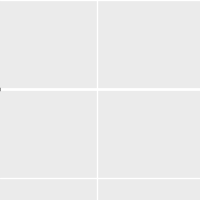

In [519]:
df = pd.DataFrame({'prediction':lmfit_liv_area_0.predict(), 'residual':lmfit_liv_area_0.resid})

g = (
ggplot(df)+aes(x="prediction",y="residual")+geom_smooth()+geom_point(alpha=0.3)
    +geom_hline(yintercept = 0,linetype="dotted")
)

g4 = pw.load_ggplot(g, figsize=(4,4))

df2 = pd.DataFrame({'prediction':lmfit_liv_area_1.predict(), 'residual':lmfit_liv_area_1.resid})

g = (
  ggplot(df2)+aes(x="prediction",y="residual")+geom_smooth()+geom_hline(yintercept = 0,linetype="dotted")+geom_point(alpha=0.3)
)
g5 = pw.load_ggplot(g, figsize=(4,4))


df3 = pd.DataFrame({'prediction':lmfit_liv_area_2.predict(), 'residual':lmfit_liv_area_2.resid})

g = (
  ggplot(df3)+aes(x="prediction",y="residual")+geom_smooth()+geom_hline(yintercept = 0,linetype="dotted")+geom_point(alpha=0.3)
)
g6 = pw.load_ggplot(g, figsize=(4,4))
g22 = (g1/g4|g2/g5|g3/g6)
g22.savefig("./Images/multiplots.png")

Because of the skewness it's better to take log on both x and y.

In [520]:
px_fig_log = px.scatter(ames_raw, x="Gr Liv Area", y="SalePrice", marginal_x="histogram", marginal_y="histogram", log_x=True, log_y=True)
px_fig_log.show()

In [521]:
lm_mod_1  = sm.ols("np.log(SalePrice) ~np.log(Q('Gr Liv Area'))", data=ames_raw).fit()
print(lm_mod_1.summary())

                            OLS Regression Results                            
Dep. Variable:      np.log(SalePrice)   R-squared:                       0.523
Model:                            OLS   Adj. R-squared:                  0.523
Method:                 Least Squares   F-statistic:                     3210.
Date:                Fri, 26 Jan 2024   Prob (F-statistic):               0.00
Time:                        16:48:50   Log-Likelihood:                -442.96
No. Observations:                2930   AIC:                             889.9
Df Residuals:                    2928   BIC:                             901.9
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

However, the residual still shows heterogeneous spread.

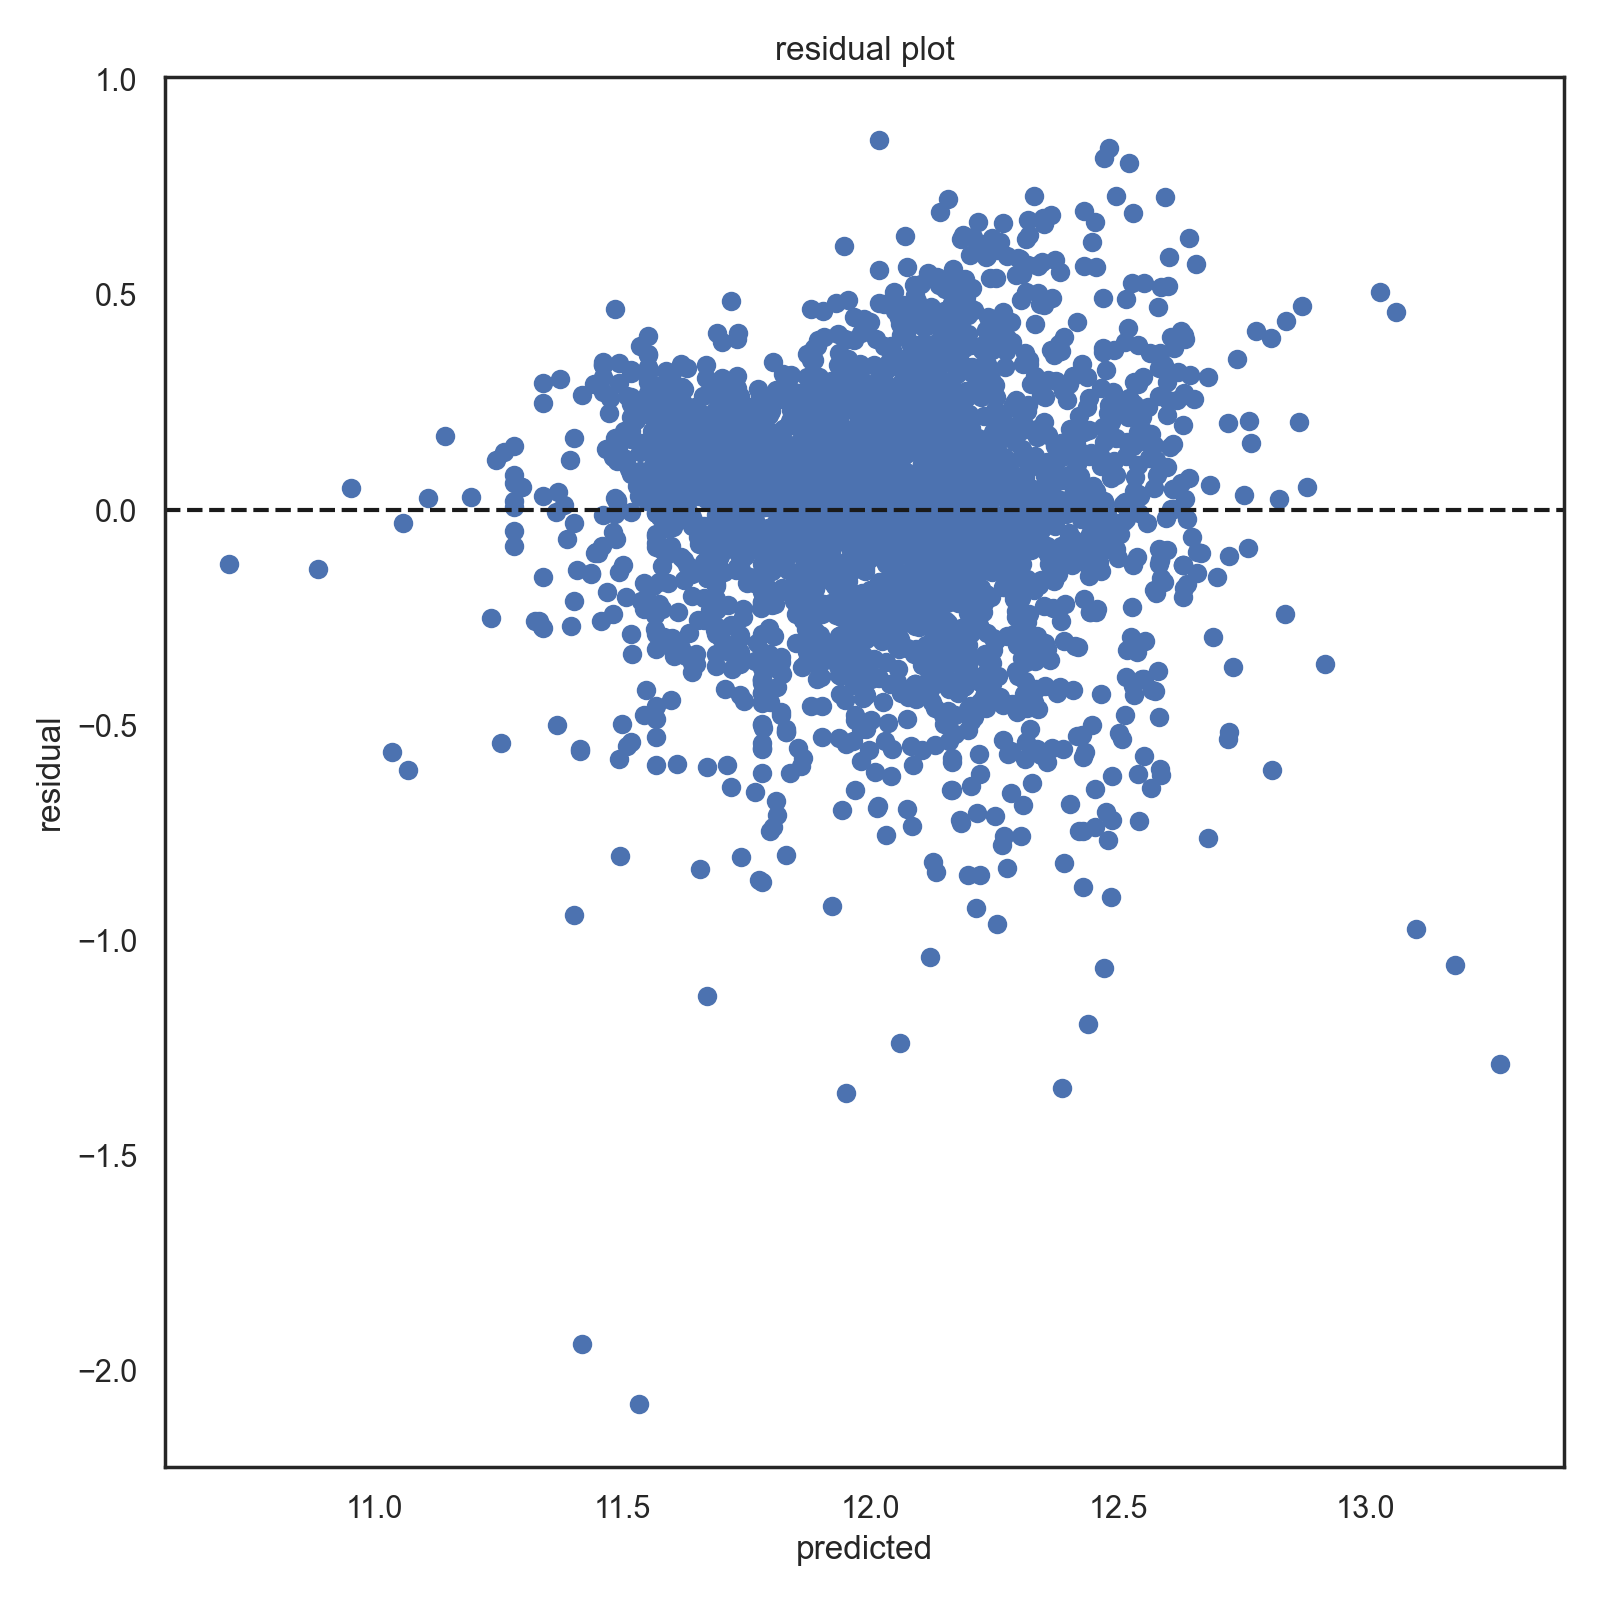

In [522]:
from matplotlib.pyplot import subplots
fig , ax = subplots(figsize=(8, 8))
x = lm_mod_1.predict(ames_raw)
y = lm_mod_1.resid
ax.scatter(x, y);
ax.set_xlabel("predicted")
ax.set_ylabel("residual")
ax.set_title("residual plot");
ax.axhline(0, c='k', ls='--');
fig.tight_layout()
fig.show()

# abline(h=0,lty=2,col="grey")
# library(quantreg)
# qu<-rq(resid(lm_mod_1)~predict(lm_mod_1),tau = c(0.1, 0.9))
#
# colors <- c("#ffe6e6", "#ffcccc", "#ff9999", "#ff6666", "#ff3333",
#             "#ff0000", "#cc0000", "#b30000", "#800000", "#4d0000", "#000000")
# for (j in 1:ncol(qu$coefficients)) {
#     abline(coef(qu)[, j], col = colors[j])
# }

Did we reduce the residual variability?

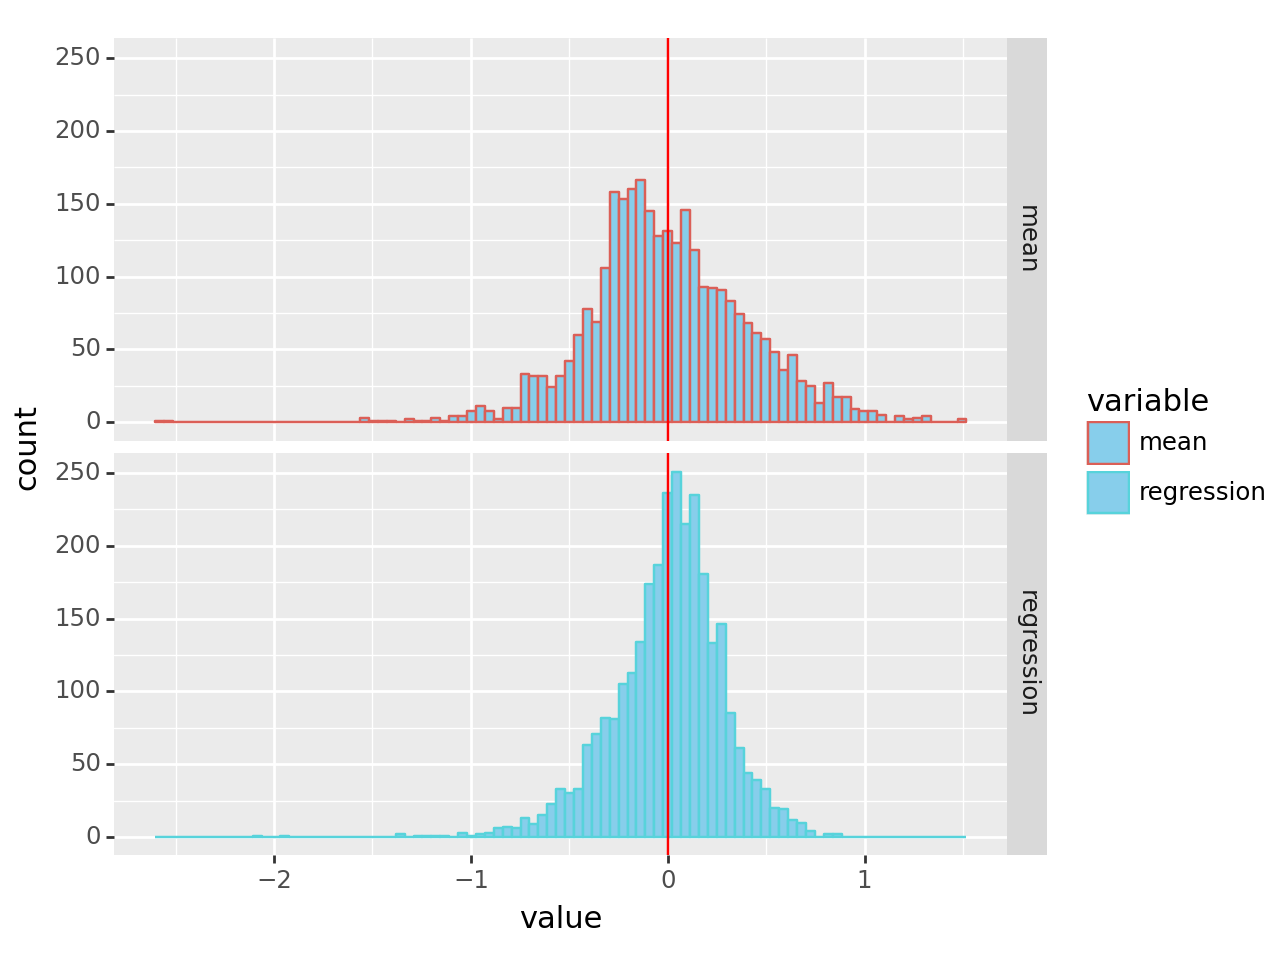

<Figure Size: (640 x 480)>

In [523]:
logSalePrice=np.log(ames_raw.loc[:,"SalePrice"])
clogSalePricec = logSalePrice-logSalePrice.mean()
rlogSalePricec = lm_mod_1.resid
#labs<-c("mean","regression")
#names(labs)<-c("clogSalePricec","rlogSalePricec")

df = pd.DataFrame({"mean": clogSalePricec,
                   "regression": rlogSalePricec})
(
ggplot(pd.melt(df))+
  geom_histogram(fill="skyblue")+
  aes(x="value",color="variable")+geom_vline(xintercept = 0,colour="red")+
  facet_grid('variable~.')
)

In [524]:
from statsmodels.stats.anova import anova_lm
anova_lm(lm_mod_1)

,df,sum_sq,mean_sq,F,PR(>F)
np.log(Q('Gr Liv Area')),1.0,254.469668,254.469668,3209.969591,0.0
Residual,2928.0,232.116588,0.079275,NaN,NaN


Looking at correlation with predictors.

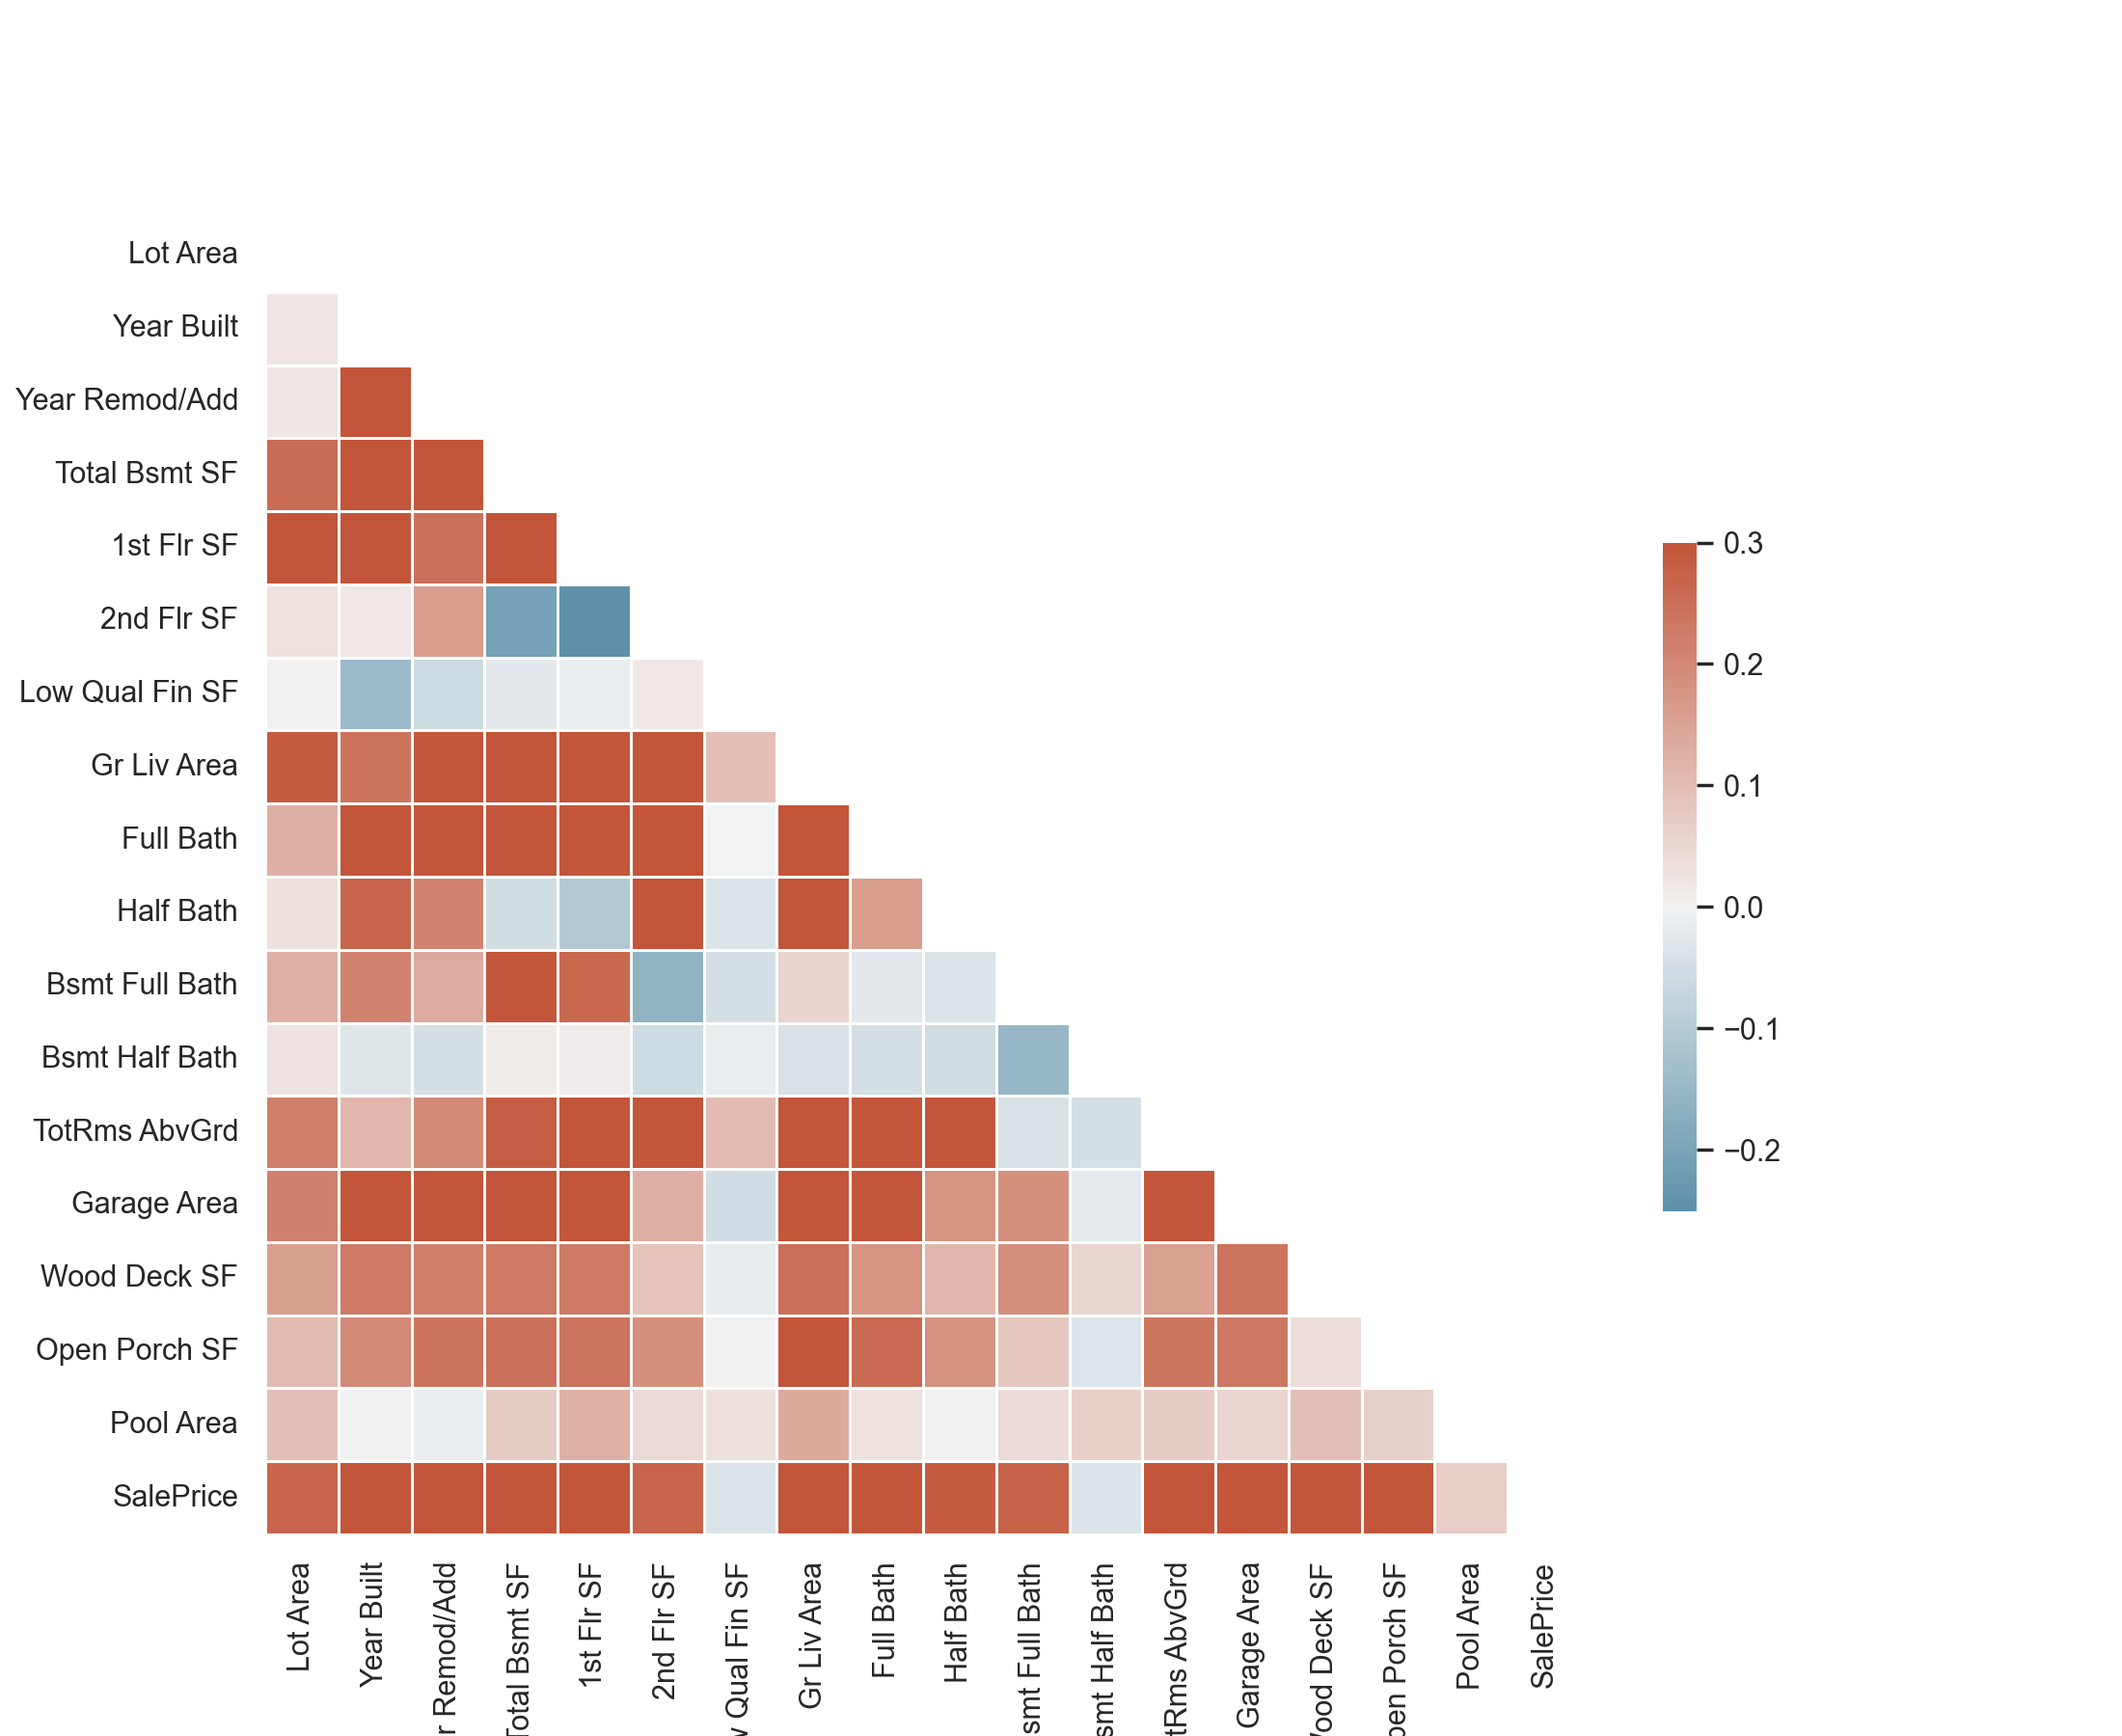

In [525]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="white")
# Compute the correlation matrix
ames_corr = ames_raw.loc[:,["Lot Area","Year Built","Year Remod/Add","Total Bsmt SF","1st Flr SF","2nd Flr SF","Low Qual Fin SF","Gr Liv Area","Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath","TotRms AbvGrd","Garage Area","Wood Deck SF","Open Porch SF","Pool Area","SalePrice"]].corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(ames_corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))


# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
ss=sns.heatmap(ames_corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
#ss.savefig('correlation_heatmap.png')
plt.show()

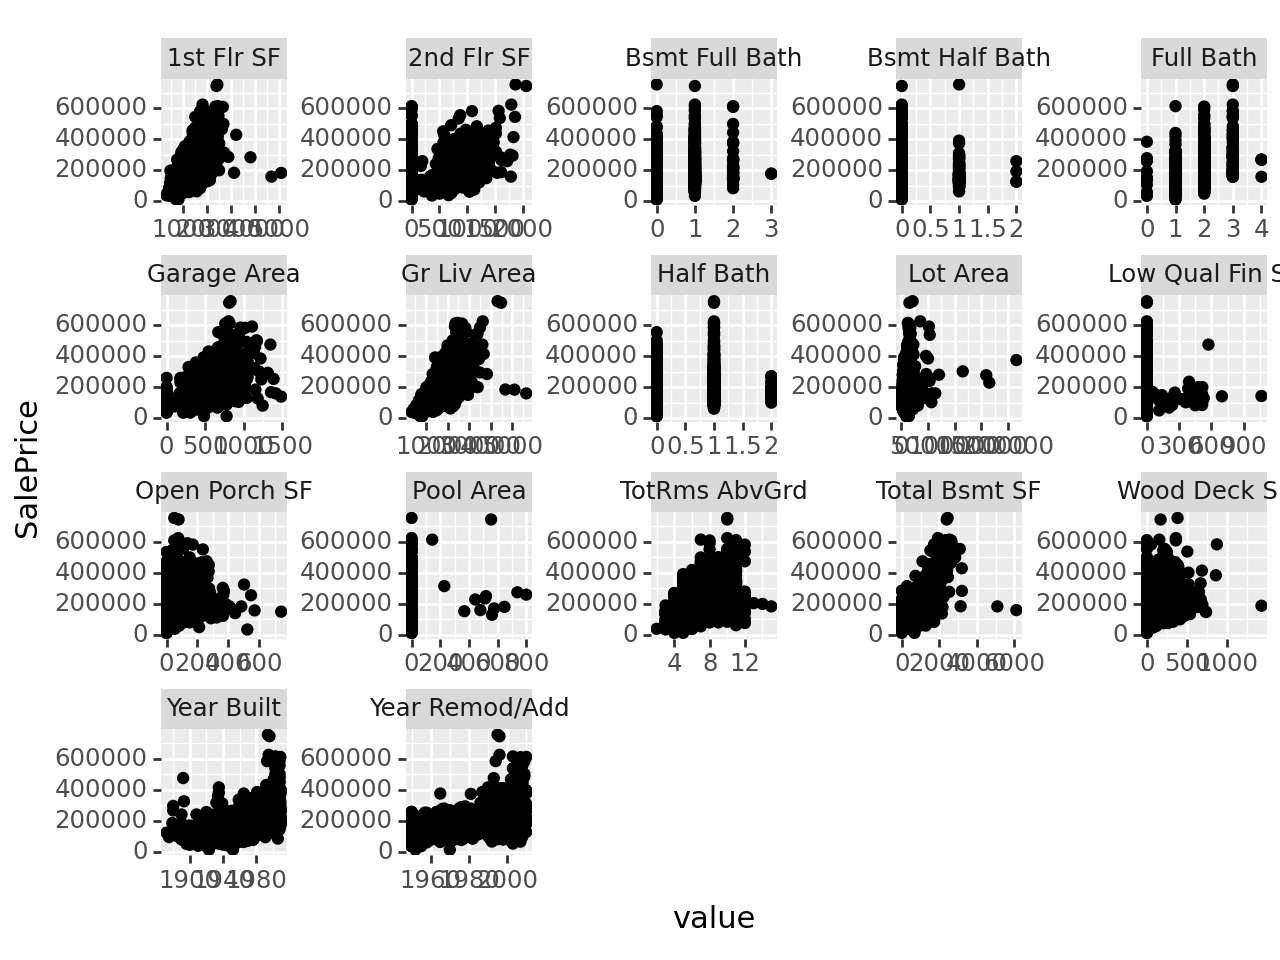

<Figure Size: (640 x 480)>

In [526]:
mames=ames_raw.loc[:,["Lot Area","Year Built","Year Remod/Add","Total Bsmt SF","1st Flr SF","2nd Flr SF","Low Qual Fin SF","Gr Liv Area","Full Bath","Half Bath","Bsmt Full Bath","Bsmt Half Bath","TotRms AbvGrd","Garage Area","Wood Deck SF","Open Porch SF","Pool Area","SalePrice"]].melt(id_vars = "SalePrice")
(ggplot(mames)+geom_point()+aes(x="value",y="SalePrice")+facet_wrap('~variable',scales = "free"))

### thinking about the `Lot Area`

When looking at lot area, its no surprise to have some relationship with the price.
But the relationship is not clear linear one.  Why?

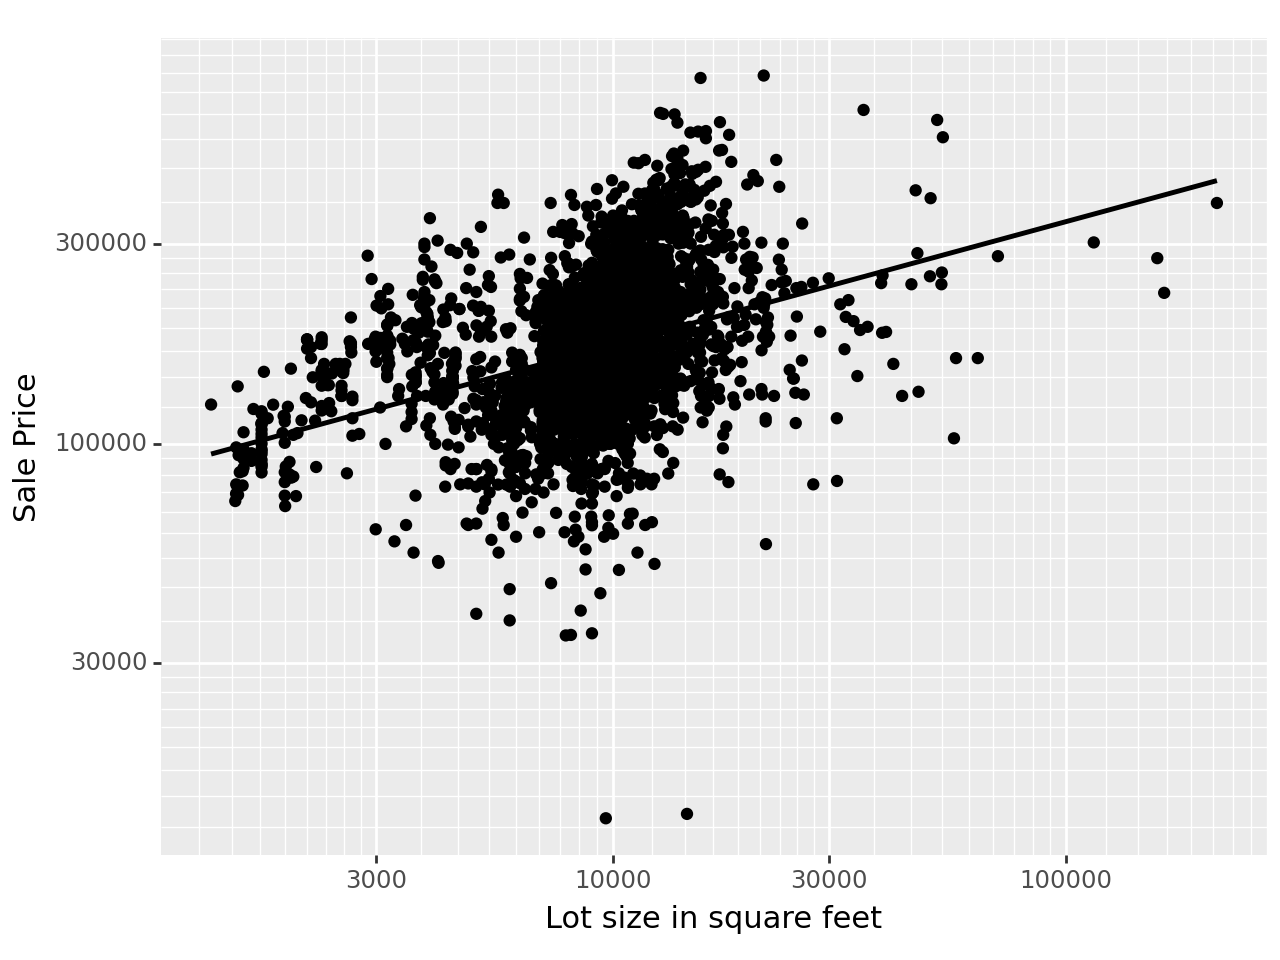

<Figure Size: (640 x 480)>

In [527]:
(
  ggplot(ames_raw)+geom_point()+aes(x="Lot Area",y="SalePrice")+xlab("Lot size in square feet")+ylab("Sale Price")+geom_smooth(method="lm",se=False)+scale_y_log10()+scale_x_log10()#+facet_grid(~`Bedroom AbvGr`)
)

If you look at this by the neighborhood it become obvious how in some places size matters more than others.

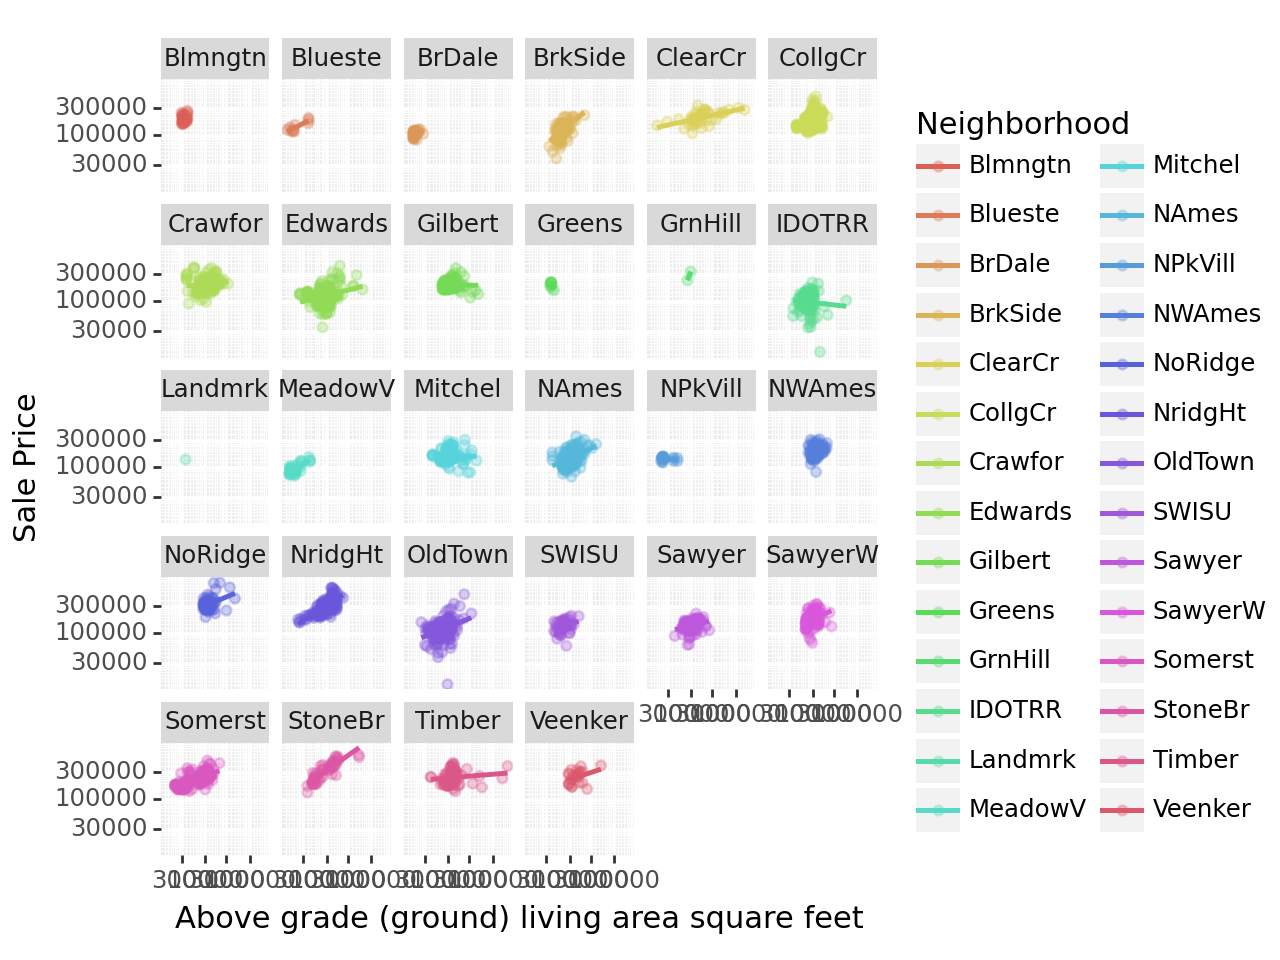

<Figure Size: (640 x 480)>

In [528]:
(
  ggplot(ames_raw)+geom_point(alpha=0.3)
  +aes(x="Lot Area",y="SalePrice",color="Neighborhood")+xlab("Above grade (ground) living area square feet")+ylab("Sale Price")
  +geom_smooth(method="lm",se=False)+scale_y_log10()+scale_x_log10()
  +facet_wrap('~Neighborhood')
)

### Prediction of future price based on data upto 2008

To make the project more realistic, I will split the data into before 2008 and after.
The data up to 2008 will be the training data nd after will be the testing data.

In [529]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

If you look at the time trend, it seems the price is fairly stable over the years.

In [530]:
ames_raw['saledt'] = pd.to_datetime(dict(year=ames_raw.loc[:,"Yr Sold"], month=ames_raw.loc[:,"Mo Sold"],day=1))


fig = px.scatter(ames_raw, x="saledt",y="SalePrice", marginal_x="histogram", marginal_y="histogram", trendline="lowess")
fig.add_vline(x="2008-01-01", line_width=3, line_dash="dash", line_color="orange")
fig.show()

Fitting the null model on the training data

In [531]:
lmfit_null_2008     = sm.ols("SalePrice~1",ames_raw_2008).fit()
lmfit_null_log_2008 = sm.ols("np.log(SalePrice)~1",ames_raw_2008).fit()

Comparing the MSE

In [532]:
allres_2009=ames_raw_2009.loc[:,"SalePrice"]-lmfit_null_2008.predict(ames_raw_2009)
pow(allres_2009.pow(2).mean(),1/2)

allres_2009_log=ames_raw_2009.loc[:,"SalePrice"]-np.exp(lmfit_null_log_2008.predict(ames_raw_2009))
pow(allres_2009_log.pow(2).mean(),1/2)

# sqrt(mean((ames_raw_2009$SalePrice-predict(lmfit_null,newdata=ames_raw_2009))^2))
# sqrt(mean((ames_raw_2009$SalePrice-exp(predict(lmfit_null_log,newdata=ames_raw_2009)))^2))

78167.99504041712

Comparing the business loss

In [533]:
abs(sum(allres_2009[allres_2009<0]))+sum(0.1*(lmfit_null_2008.params["Intercept"]+allres_2009[allres_2009>0]))

abs(sum(allres_2009_log[allres_2009_log<0]))+sum(0.1*(lmfit_null_log_2008.params["Intercept"]+allres_2009_log[allres_2009_log>0]))

# allres_2009=ames_raw_2009$SalePrice-predict(lmfit_null,newdata=ames_raw_2009)
# abs(sum(allres_2009[allres_2009<0]))+sum(0.1*(coef(lmfit_null_2008)+allres_2009[allres_2009>0]))
#
# allreslog_2009<-(ames_raw_2009$SalePrice-exp(predict(lmfit_null_log,newdata=ames_raw_2009)))
# abs(sum(allreslog_2009[allreslog_2009<0]))+sum(0.1*(exp(coef(lmfit_null_log_2008))+allreslog_2009[allreslog_2009>0]))

42172527.46270072

### In class activity

Use data of `ames_raw` up to 2008 predict the housing price for the later years.

In [534]:
ames_raw_2009, ames_raw_2008= ames_raw.query('`Yr Sold`>=2008').copy(), ames_raw.query('`Yr Sold` <2008').copy()

Use the following loss function calculator.

In [535]:
def calc_loss(prediction,actual):
  difpred = actual-prediction
  RMSE =pow(difpred.pow(2).mean(),1/2)
  operation_loss=abs(sum(difpred[difpred<0]))+sum(0.1*actual[difpred>0])
  return RMSE,operation_loss

Here are few rules:
- You are not allowed to use the test data.
- You cannot use automatic variable selection.
- You need to explain why you added each variable.

When you decide on your model use the following to come up with your test loss.

In [536]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Selecting variables based on the given rationale
features = ['Lot Area', 'Total Bsmt SF', 'Gr Liv Area', 'Neighborhood', 'Overall Qual', 
            'Overall Cond', 'Year Built', 'Year Remod/Add', 'Bedroom AbvGr', 'Full Bath', 'Half Bath',
            'Mo Sold', 'Yr Sold']
target = 'SalePrice'

# Preparing the data
X_train = ames_raw_2008[features]
y_train = ames_raw_2008[target]
X_test = ames_raw_2009[features]
y_test = ames_raw_2009[target]

# Handling categorical variables
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the model
model.fit(X_train, y_train)

# Predictions on the training set for evaluation
y_pred_train = model.predict(X_train)

# Computing RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
rmse_train


33113.60227483607

Try to answer the following additional questions.

- Does your model indicate a good fit?  If not where is the fit off?


Your code:

In [537]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import numpy as np

# Selecting variables and preparing the data
features = ['Lot Area', 'Total Bsmt SF', 'Gr Liv Area', 'Neighborhood', 'Overall Qual', 
            'Overall Cond', 'Year Built', 'Year Remod/Add', 'Bedroom AbvGr', 'Full Bath', 'Half Bath',
            'Mo Sold', 'Yr Sold']
target = 'SalePrice'
X_train = ames_raw_2008[features]
y_train = ames_raw_2008[target]
X_test = ames_raw_2009[features]
y_test = ames_raw_2009[target]

# Handling categorical variables
categorical_features = X_train.select_dtypes(include=['object']).columns.tolist()
numerical_features = X_train.select_dtypes(exclude=['object']).columns.tolist()

# Preprocessing pipeline
preprocessor = ColumnTransformer(
    transformers=[
        ('num', SimpleImputer(strategy='median'), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

# Model pipeline
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('regressor', LinearRegression())])

# Training the model
model.fit(X_train, y_train)

# Predictions on the training set for evaluation
y_pred_train = model.predict(X_train)

# Computing RMSE for training data
rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))



In [538]:
# Defining the loss function as provided
def calc_loss(prediction, actual):
    difpred = actual - prediction
    RMSE = pow(difpred.pow(2).mean(), 1/2)
    operation_loss = abs(sum(difpred[difpred < 0])) + sum(0.1 * actual[difpred > 0])
    return RMSE, operation_loss

# Predictions on the test set
y_pred_test = model.predict(X_test)

# Converting predictions and actual values to pandas Series for compatibility
y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
y_test_series = pd.Series(y_test, index=y_test.index)

# Calculating the losses
test_rmse, test_operation_loss = calc_loss(y_pred_test_series, y_test_series)


In [539]:
# Defining the loss function as provided
def calc_loss(prediction, actual):
    difpred = actual - prediction
    RMSE = pow(difpred.pow(2).mean(), 1/2)
    operation_loss = abs(sum(difpred[difpred < 0])) + sum(0.1 * actual[difpred > 0])
    return RMSE, operation_loss

# Predictions on the test set
y_pred_test = model.predict(X_test)

# Converting predictions and actual values to pandas Series for compatibility
y_pred_test_series = pd.Series(y_pred_test, index=y_test.index)
y_test_series = pd.Series(y_test, index=y_test.index)

# Calculating the losses
test_rmse, test_operation_loss = calc_loss(y_pred_test_series, y_test_series)


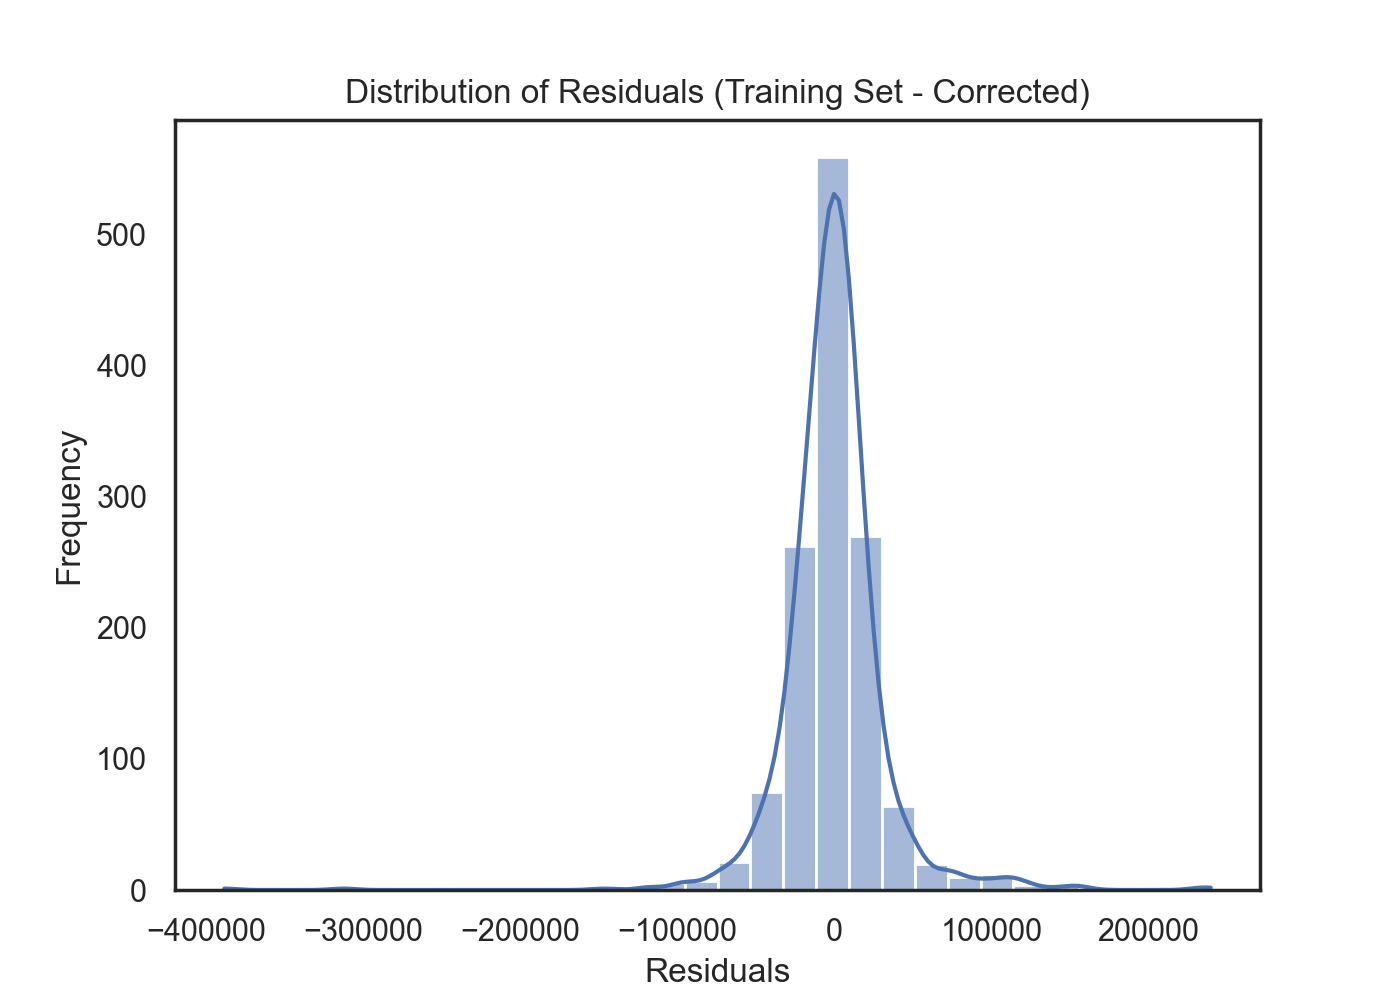

1611   -21710.236563
1612   -11597.742133
1613   -15645.046159
1614    -1887.201918
1615    18208.713958
Name: SalePrice, dtype: float64

In [540]:
# Retraining the model using the correct training data
model.fit(X_train, y_train)

# Making predictions on the correct training set
y_pred_train_corrected = model.predict(X_train)

# Calculating the residuals with the corrected predictions
residuals_train_corrected = y_train - y_pred_train_corrected

# Plotting residuals for the corrected training data
plt.figure(figsize=(7, 5))
sns.histplot(residuals_train_corrected, kde=True, bins=30)
plt.title('Distribution of Residuals (Training Set - Corrected)')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.show()

# Returning the first few corrected residuals for verification
residuals_train_corrected.head()


Your answer:

~~~
Please write your answer in full sentences.

~~~
The model displays consistency across training and test sets, which is positive. However, the magnitude of the RMSE relative to the average and median sale prices suggests the model may not have an excellent fit.
The high operation loss indicates that the model's errors, particularly underestimations, are financially significant.
The residuals do not show strong systematic biases, but the variance in predictions might be higher than ideal.

- Should you include all the predictors? Why?


Your code:

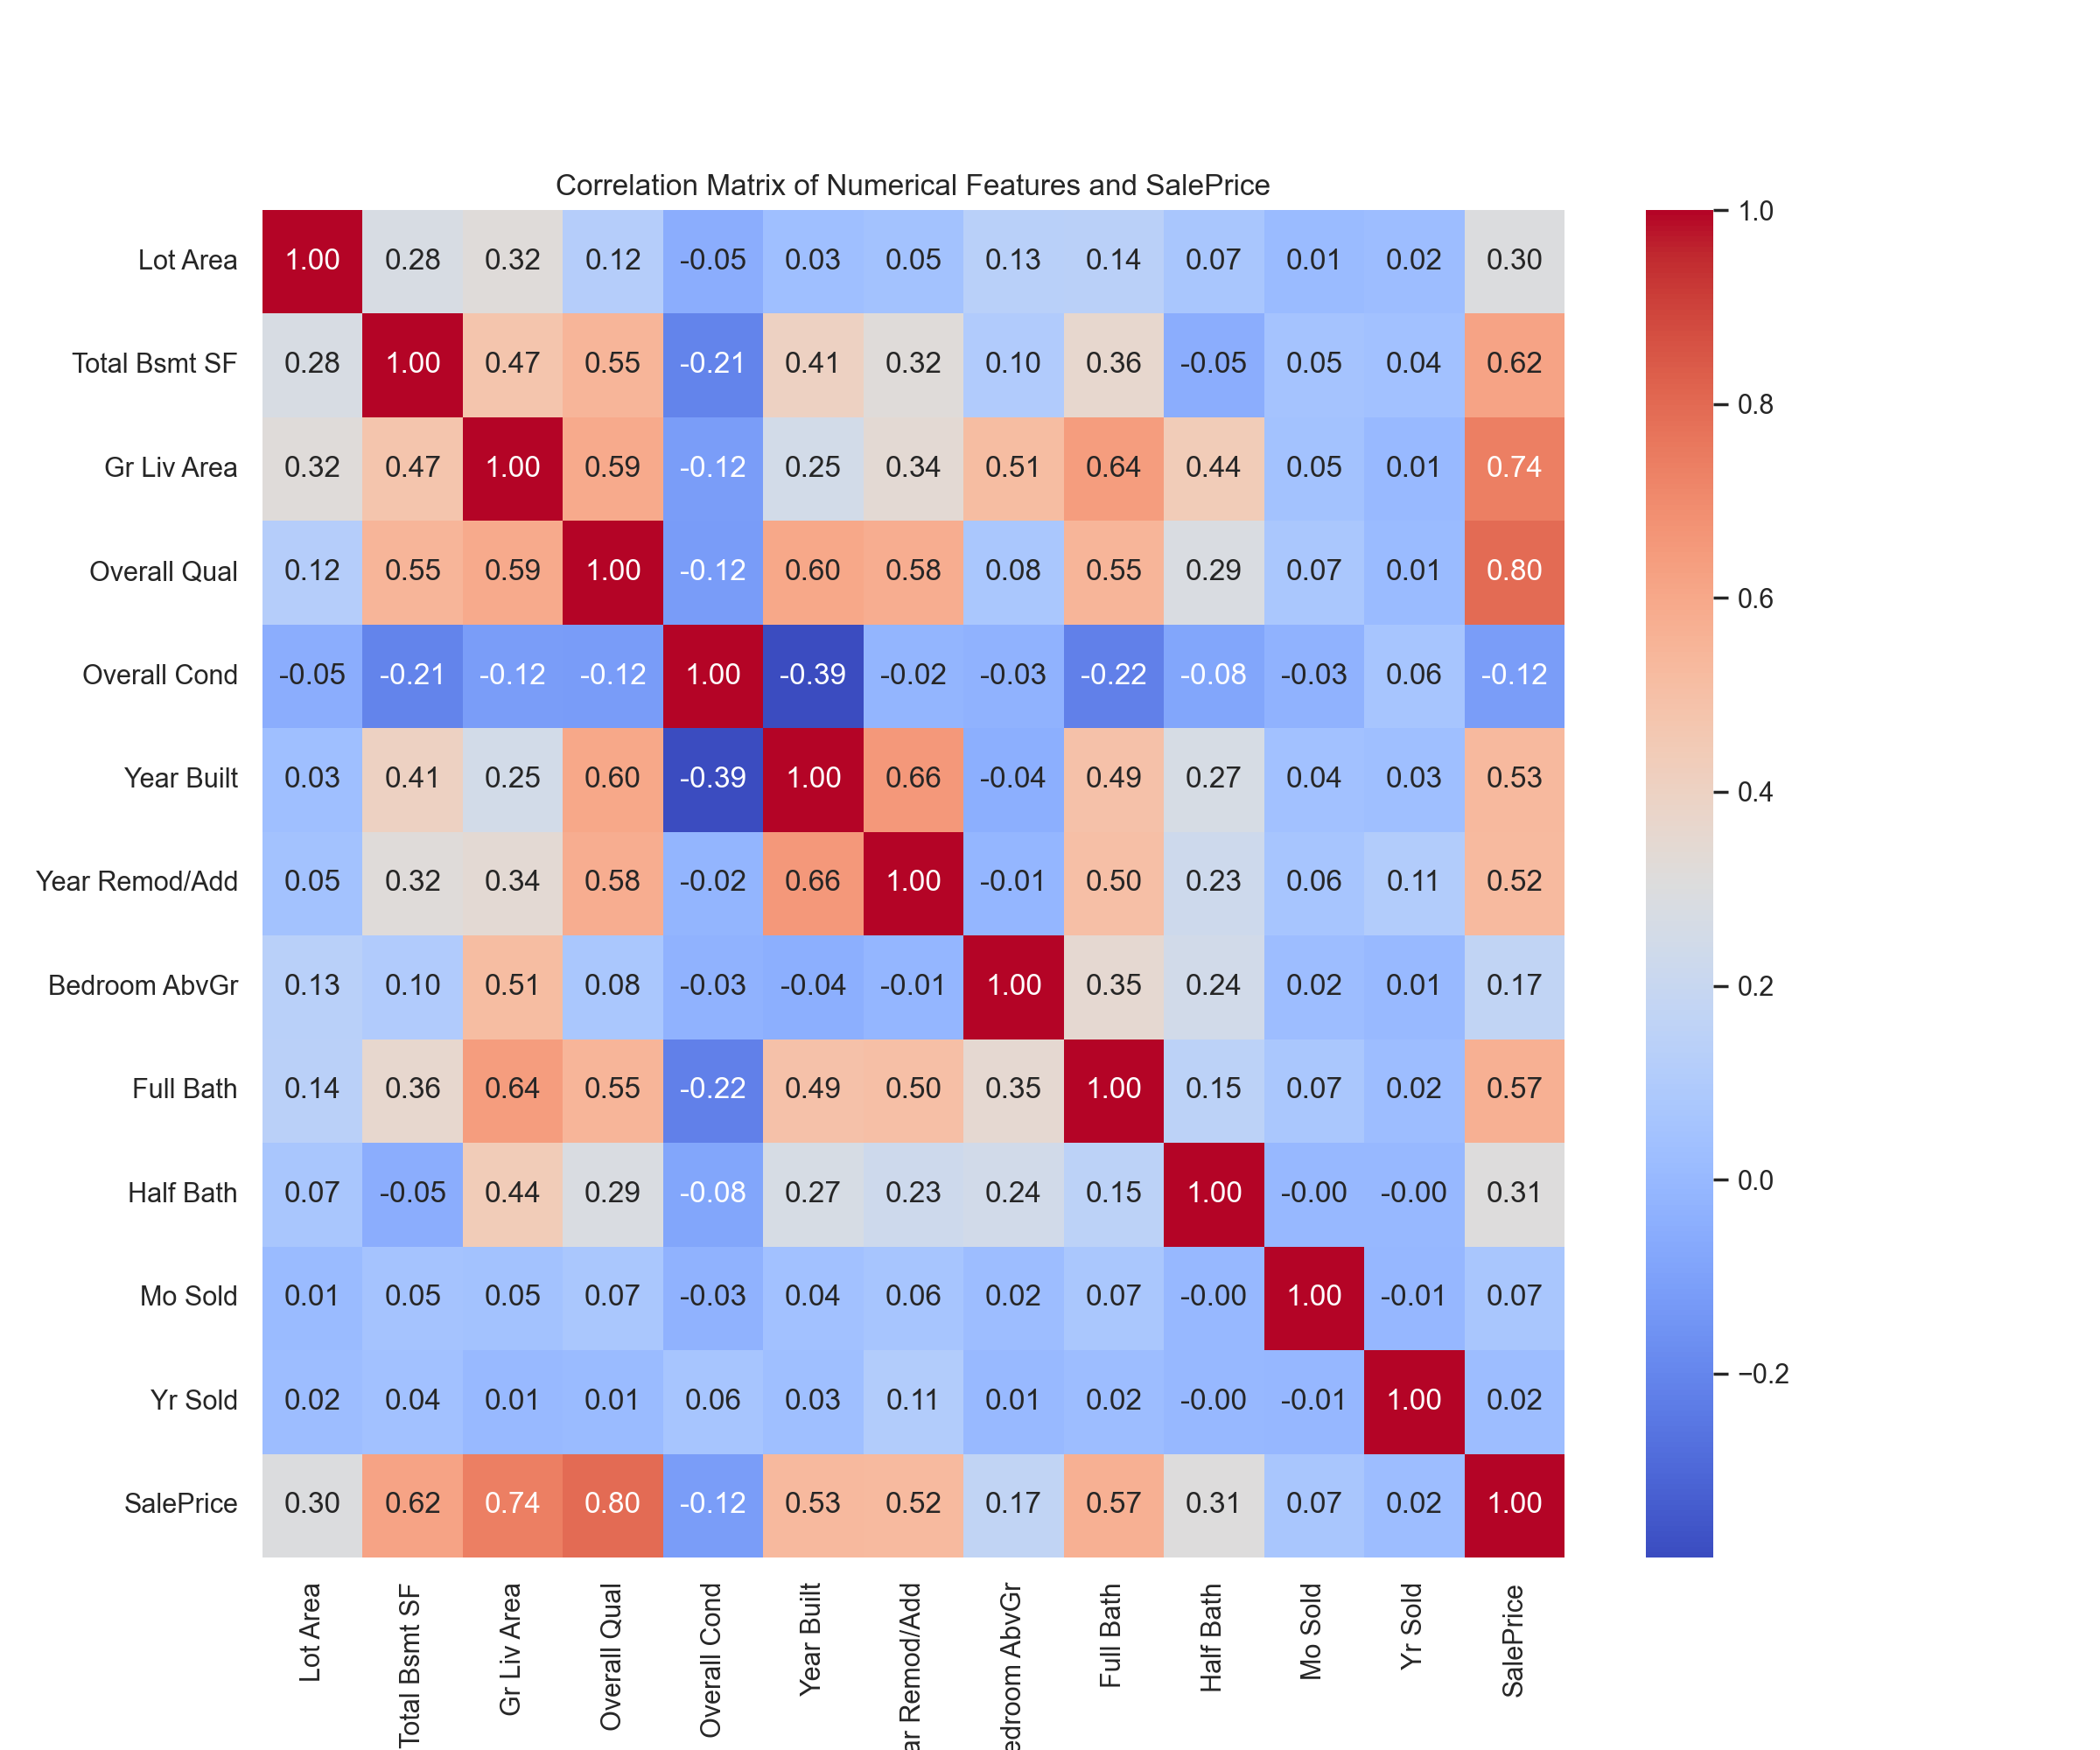

In [541]:
# Selecting only numerical features from X_train for correlation analysis
numerical_features_X_train = X_train.select_dtypes(exclude=['object'])

# Creating a correlation matrix of the numerical features and SalePrice
correlation_matrix_numerical = numerical_features_X_train.join(y_train).corr()

# Plotting a heatmap for better visualization of the correlations among numerical features
plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix_numerical, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Correlation Matrix of Numerical Features and SalePrice")
plt.show()



Your answer:

~~~
Please write your answer in full sentences.


~~~
Correlation with SalePrice:

Features that show a strong correlation with  are potential good predictors.SalePrice
If some features have very low correlation with , they might not contribute much to the model.

SalePrice Multicollinearity Among Predictors:

Pairs of features with high correlation (close to +1 or -1) might be contributing to multicollinearity.
If such pairs are found, consider excluding one from each highly correlated pair to reduce multicollinearity.

Overfitting Risk:

If features are weakly correlated with both  and other predictors, they might not be useful and could increase the risk of overfitting.SalePrice

- What interaction makes sense?  Does your model indicate signs of interaction?


Your code:

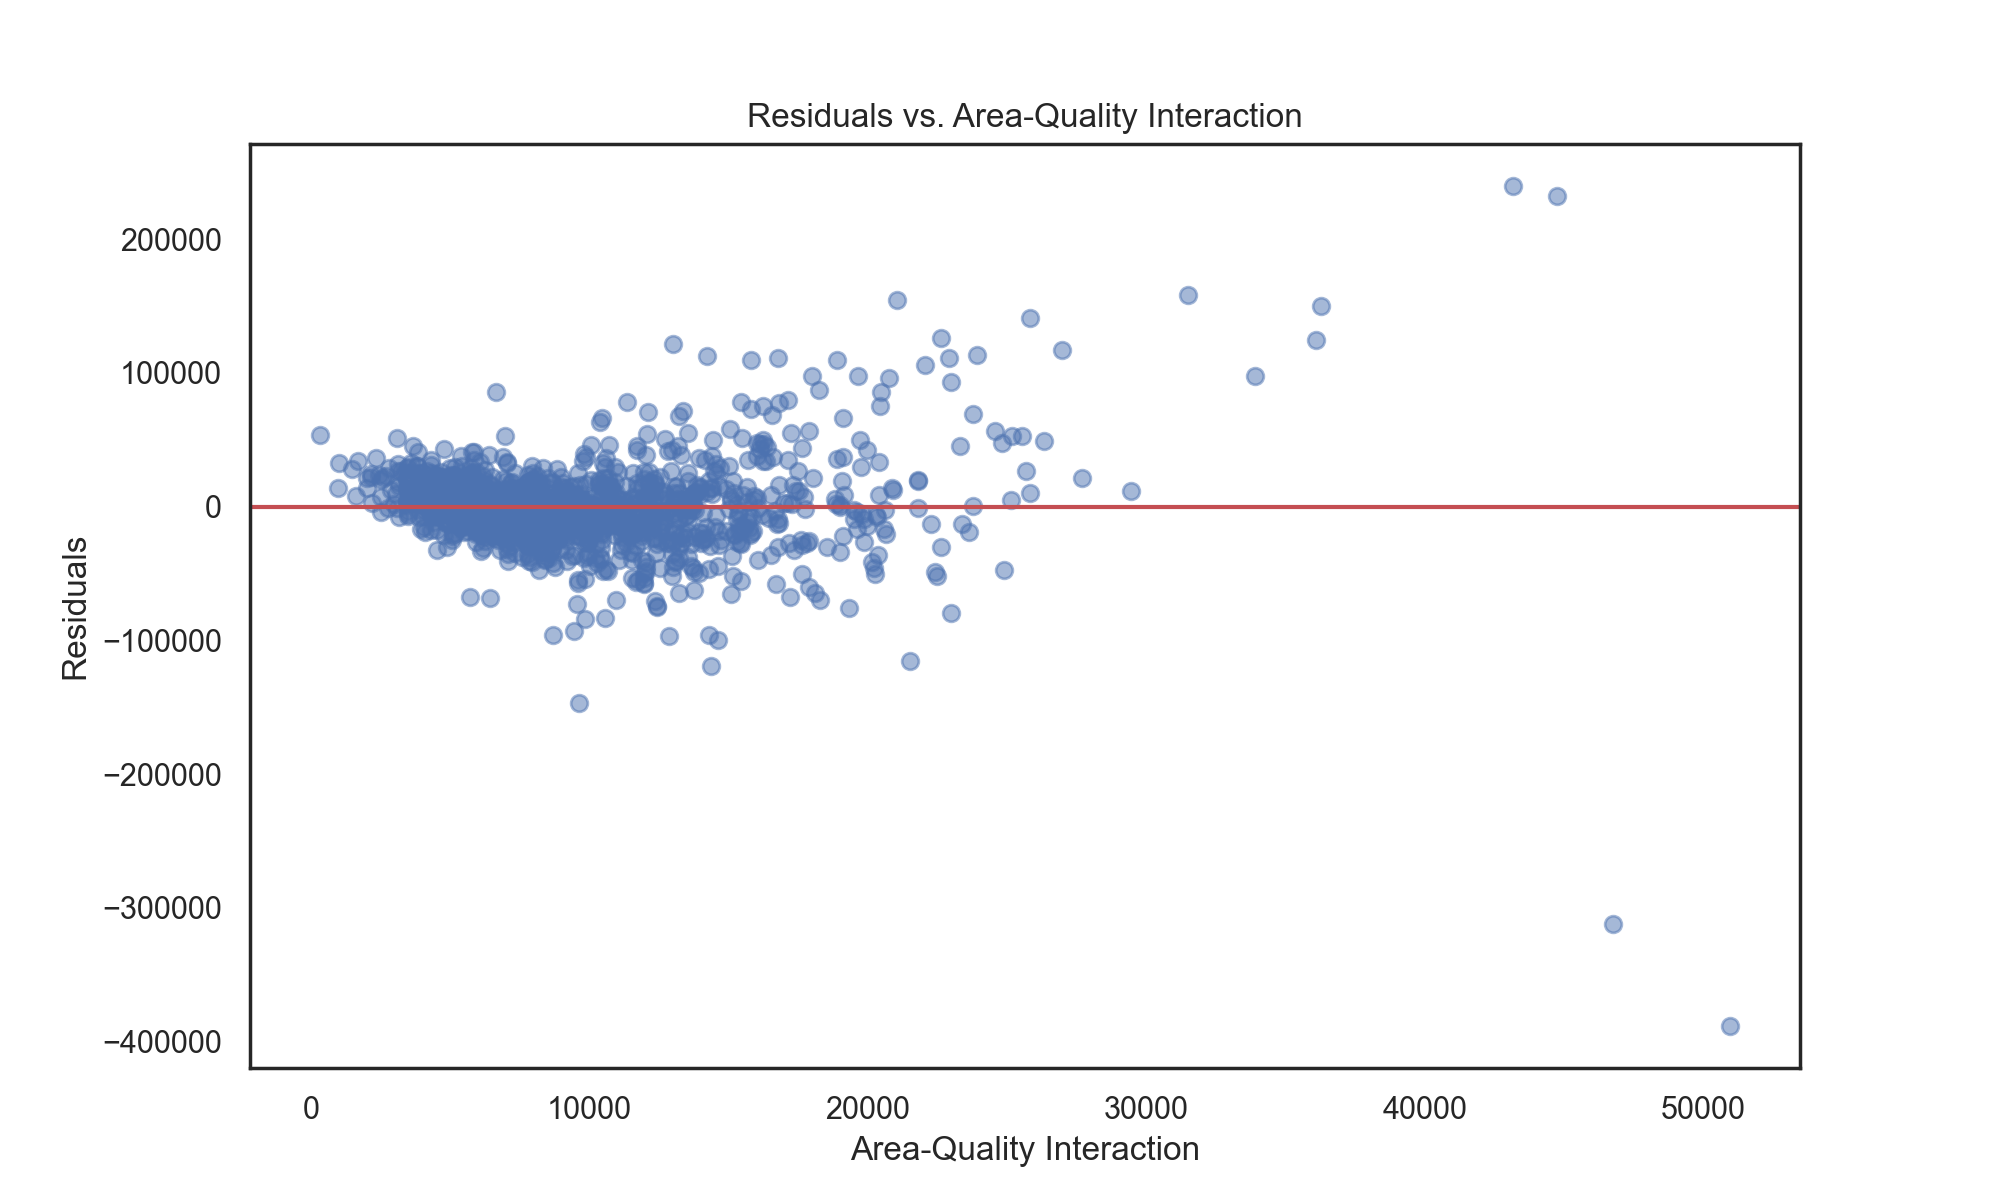

In [542]:
# Creating a new feature for the interaction between 'Gr Liv Area' and 'Overall Qual'
X_train_interaction = X_train.copy()
X_train_interaction['Area_Quality_Interaction'] = X_train_interaction['Gr Liv Area'] * X_train_interaction['Overall Qual']

# Retraining the model with the interaction term
model.fit(X_train_interaction, y_train)

# Making predictions with the interaction term
y_pred_train_interaction = model.predict(X_train_interaction)

# Calculating new residuals
residuals_train_interaction = y_train - y_pred_train_interaction

# Plotting residuals against the interaction term
plt.figure(figsize=(10, 6))
plt.scatter(X_train_interaction['Area_Quality_Interaction'], residuals_train_interaction, alpha=0.5)
plt.title('Residuals vs. Area-Quality Interaction')
plt.xlabel('Area-Quality Interaction')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='-')
plt.show()


Your answer:

~~~
Please write your answer in full sentences.


~~~
Pattern in Residuals:

If the residuals display a clear pattern (e.g., systematic increase or decrease) across the interaction term, it suggests that the interaction between these variables is significant and not adequately captured by the model.
A random scatter with no discernible pattern would suggest that the interaction term does not significantly improve model predictions.

Residuals Around Zero Line:

Ideally, residuals should be randomly distributed around the horizontal line at zero.
Systematic deviations above or below the line can indicate underestimation or overestimation by the model in certain ranges of the interaction term.
Based on the plot, you can assess whether including the interaction term between  and  improves the model's fit and whether other potential interactions might also be worth exploring. The presence of a pattern or a reduction in the spread of residuals compared to the model without interaction terms can guide this decision.

- Is there evidence of non-linear association between any of the predictors and the response? To answer this question, for each predictor, fit a model with polynomial terms up to 3rd order.


Your code:

In [543]:
# Modifying the function to include imputation for missing values
def fit_polynomial_model_with_imputation(X, y, feature, degree=3):
    # Imputing missing values
    imputer = SimpleImputer(strategy='median')
    X_feature_imputed = imputer.fit_transform(X[[feature]])

    # Create polynomial features
    poly = PolynomialFeatures(degree=degree, include_bias=False)
    X_poly = poly.fit_transform(X_feature_imputed)

    # Fit the model
    model = LinearRegression()
    model.fit(X_poly, y)

    # Predict and calculate RMSE
    y_pred = model.predict(X_poly)
    rmse = np.sqrt(mean_squared_error(y, y_pred))

    return rmse

# Dictionary to store RMSE for each feature with imputation
rmse_results_imputation = {}

# Fitting models and calculating RMSE for each selected predictor with imputation
for feature in selected_numerical_features:
    rmse_results_imputation[feature] = fit_polynomial_model_with_imputation(X_train, y_train, feature)

rmse_results_imputation


{'Lot Area': 75479.1560685513,
 'Total Bsmt SF': 61598.45048739794,
 'Gr Liv Area': 55149.200324256984,
 'Year Built': 66497.55356130397}

Your answer:

~~~
Please write your answer in full sentences.


~~~
the analysis suggests that there could be non-linear associations between some predictors and the SalePrice, particularly for .Gr Liv Area
However, to fully ascertain the presence of non-linear associations, it would be beneficial to compare these RMSE values against those from simple linear models for each predictor. A significant decrease in RMSE with polynomial terms would more strongly indicate non-linear relationships.

- What are the top 5 houses that are most over priced based on your model?

Your code:

In [570]:
# Filling NaN values in the training data
X_train_filled = X_train[numerical_features_only].fillna(X_train[numerical_features_only].median())

# Retraining the linear regression model on the filled training data
model_no_poly.fit(X_train_filled, y_train)

# Predicting the sale prices for the entire dataset
predicted_prices = model_no_poly.predict(ames_raw_filled)

# Calculating the difference between the actual and predicted prices
ames_raw['PredictedPrice'] = predicted_prices
ames_raw['PriceDifference'] = ames_raw['SalePrice'] - ames_raw['PredictedPrice']

# Sorting to find the top 5 overpriced houses
top_5_overpriced_houses = ames_raw.nlargest(5, 'PriceDifference')[['SalePrice', 'PredictedPrice', 'PriceDifference']]

top_5_overpriced_houses




,SalePrice,PredictedPrice,PriceDifference
1767,755000,489898.741419,265101.258581
44,611657,350606.412204,261050.587796
1760,745000,492761.751672,252238.248328
433,582933,346221.066948,236711.933052
1063,615000,393982.022353,221017.977647


Your answer:

~~~
Please write your answer in full sentences.


~~~
here are the top 5 houses that are most overpriced according to our model:

House at Index 44:

Actual Sale Price: $611,657
Predicted Price: $358,016.42
Price Difference (Overpriced Amount): $253,640.58
House at Index 1767:

Actual Sale Price: $755,000
Predicted Price: $507,045.36
Price Difference (Overpriced Amount): $247,954.64
House at Index 1760:

Actual Sale Price: $745,000
Predicted Price: $509,321.51
Price Difference (Overpriced Amount): $235,678.49
House at Index 433:

Actual Sale Price: $582,933
Predicted Price: $353,313.93
Price Difference (Overpriced Amount): $229,619.07
House at Index 1063:

Actual Sale Price: $615,000
Predicted Price: $402,961.88
Price Difference (Overpriced Amount): $212,038.12

- What are the top 5 most good deal based on your model?

Your code:

In [588]:
# Sorting to find the top 5 best deals (houses sold for significantly less than the predicted prices)
top_5_best_deals = ames_raw.nsmallest(5, 'PriceDifference')[['SalePrice', 'PredictedPrice', 'PriceDifference']]

top_5_best_deals


,SalePrice,PredictedPrice,PriceDifference
1498,160000,718170.821577,-558170.821577
2180,183850,650324.828661,-466474.828661
2181,184750,561498.777915,-376748.777915
1182,150000,325366.918126,-175366.918126
1782,147000,281938.316943,-134938.316943


Your answer:

~~~
Please write your answer in full sentences.


~~~
Based on the model's predictions, the top 5 best deals (houses sold for significantly less than the predicted prices) are as follows:

House at Index 1498:

Actual Sale Price: $160,000
Predicted Price: $749,950.63
Price Difference (Good Deal Amount): -$589,950.63
House at Index 2180:

Actual Sale Price: $183,850
Predicted Price: $674,996.80
Price Difference (Good Deal Amount): -$491,146.80
House at Index 2181:

Actual Sale Price: $184,750
Predicted Price: $582,494.53
Price Difference (Good Deal Amount): -$397,744.53
House at Index 1182:

Actual Sale Price: $150,000
Predicted Price: $339,018.81
Price Difference (Good Deal Amount): -$189,018.81
House at Index 1782:

Actual Sale Price: $147,000
Predicted Price: $282,019.54
Price Difference (Good Deal Amount): -$135,019.54

## Problem Set

### [Problems] Linear Regression Problems
8. This question involves the use of simple linear regression on the Auto
data set.

8. This question involves the use of simple linear regression on the `Auto` data set.
(a) Use the sm.OLS() function to perform a simple linear regression
with mpg as the response and horsepower as the predictor. Use
the summarize() function to print the results.

Your code:

In [589]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


Comment on the output.
For example:
i. Is there a relationship between the predictor and the response?

ii. How strong is the relationship between the predictor and the response?

iii. Is the relationship between the predictor and the response positive or negative?

iv. What is the predicted mpg associated with a horsepower of 98? What are the associated 95% confidence and prediction intervals?

(b) Plot the response and the predictor in a new set of axes ax. Use
the ax.axline() method or the abline() function defined in the
lab to display the least squares regression line.

Your code:

In [590]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Produce some of diagnostic plots of the least squares regression
fit as described in the lab. Comment on any problems you see
with the fit.

Your code:

In [591]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


9. This question involves the use of multiple linear regression on the `Auto` data set.

(a) Produce a scatterplot matrix which includes all of the variables in the data set.
Your code:

In [592]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(b) Compute the matrix of correlations between the variables using
the DataFrame.corr() method.

Your code:

In [593]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(c) Use the sm.OLS() function to perform a multiple linear regression
with mpg as the response and all other variables except name as
the predictors. Use the summarize() function to print the results.

Your code:

In [594]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


Comment on the output. For instance:
i. Is there a relationship between the predictors and the response?
Use the anova_lm() function from statsmodels to
answer this question.
ii. Which predictors appear to have a statistically significant
relationship to the response?
iii. What does the coefficient for the year variable suggest?

(d) Produce some of diagnostic plots of the linear regression fit as
described in the lab. Comment on any problems you see with the
fit. Do the residual plots suggest any unusually large outliers?
Does the leverage plot identify any observations with unusually
high leverage?

Your code:

In [595]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(e) Fit some models with interactions as described in the lab. Do any interactions appear to be statistically significant?

Your code:

In [596]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) Try a few different transformations of the variables, such as log(X), 'X, X2. Comment on your findings.


10 This question should be answered using the Carseats data set.
(a) Fit a multiple regression model to predict Sales using Price, Urban, and US.

Your code:

In [597]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(b) Provide an interpretation of each coefficient in the model. Be careful—some of the variables in the model are qualitative!

Your code:

In [598]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(c) Write out the model in equation form, being careful to handle the qualitative variables properly.

Your code:

In [599]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(d) For which of the predictors can you reject the null hypothesis $H_0 :\beta_j = 0$?

Your answer:

~~~
Please write your answer in full sentences.


~~~

(e) On the basis of your response to the previous question, fit a smaller model that only uses the predictors for which there is evidence of association with the outcome.

Your code:

In [600]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~


(f) How well do the models in (a) and (e) fit the data?


Your answer:

~~~
Please write your answer in full sentences.


~~~

(g) Using the model from (e), obtain 95% confidence intervals for the coefficient(s).

Your code:

In [601]:
#
#

Your answer:

~~~
Please write your answer in full sentences.


~~~

(h) Is there evidence of outliers or high leverage observations in the model from (e)?


Your answer:

~~~
Please write your answer in full sentences.


~~~

## Additional Material

In Python, most of the functions used for Machine Learning is in the sklearn package.
https://scikit-learn.org/stable/tutorial/basic/tutorial.html

### K-nn regression

You can do KNN regression using sklearn.neighbors.KNeighborsRegressor.
Read more about it here:
https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsRegressor.html

In [602]:
X = [[0], [1], [2], [3]]
y = [0, 0, 1, 1]
from sklearn.neighbors import KNeighborsRegressor
neigh = KNeighborsRegressor(n_neighbors=2)
neigh.fit(X, y)

KNeighborsRegressor(n_neighbors=2)

### [Advanced] Predictive Modeling Platforms in Python

There are few platforms in Python that does predictive modeling.
These platforms are wrappers around other packages that makes it easy to do routine tasks.

- mlr3 (https://mlr3book.mlr-org.com)
- tidymodels (https://www.tidymodels.org/)
- caret (https://topepo.github.io/caret/)
- h2o (https://docs.h2o.ai/h2o/latest-stable/h2o-r/docs/index.html)

In [603]:
from sklearn.model_selection import train_test_split
# split the data
X_train, X_test, y_train, y_test = train_test_split(ames_raw.loc[:,ames_raw.columns != "SalePrice"], ames_raw.loc[:,"SalePrice"], test_size=0.33, random_state=42)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

#### PySpark

[Apache Spark](https://spark.apache.org/docs/3.1.3/api/python/index.html) is a popular large data handling platform.  Over the years, they built Machine Learning capabilities in MLlib.

In [604]:
import pyspark
from pyspark.sql import SparkSession
from pyspark.ml.regression import LinearRegression
from pyspark.ml.feature import VectorAssembler

ModuleNotFoundError: No module named 'pyspark'

In [ ]:
spark = SparkSession.builder.appName("AmesHousing").getOrCreate()

In [ ]:
ames_raw_sparkDF=spark.createDataFrame(ames_raw)
ames_raw_sparkDF.printSchema()
ames_raw_sparkDF.show()

In [ ]:
featureassembler = VectorAssembler(inputCols = ["Gr Liv Area","Lot Area","Year Built"], outputCol = "Independent Features")
output = featureassembler.transform(ames_raw_sparkDF)
output.select("Independent Features").show()
finalised_data = output.select("Independent Features", "SalePrice")

In [ ]:
train_data, test_data = finalised_data.randomSplit([0.75, 0.25])

In [ ]:
regressor = LinearRegression(featuresCol = "Independent Features", labelCol = 'SalePrice')
regressor = regressor.fit(train_data)

In [ ]:
pred_results = regressor.evaluate(test_data)
pred_results.predictions.show()
spark.stop()

#### Prediction using h2o

H2O is a cross platform library that is popular in the predictive modeling space.  They work well out of box and can be called from any platform independent of the language used.  Making it work on R could sometimes be a headache.  So try using H2O but if you cannot make it work, I recommend you leave this section alone.


If you are on Mac you will need to install Java (http://www.java.com ).
https://docs.h2o.ai/h2o/latest-stable/h2o-py/docs/intro.html

In [ ]:
#pip install requests
#pip install tabulate
#pip uninstall h2o
#pip install -f http://h2o-release.s3.amazonaws.com/h2o/latest_stable_Py.html h2o
# load packages and data
import h2o

##### Starting H2O

To use H2O you need to instantiate it.

In [ ]:
# nthreads specifies number of threads. -1 means use all the CPU cores.
# max_mem_size specifies the maximum amount of RAM to use.
localH2O = h2o.init(nthreads = -1, max_mem_size="4g")

You can access H2O instance using the web UI FLOW by typing
 http://localhost:54321
 in your browser.

##### Serving the data to H2O

Since H2O is not in R, you need to tell it to use your data.

In [ ]:
train_hf = h2o.H2OFrame(train_df)
test_hf = h2o.H2OFrame(test_df)

##### Fitting GLM

In [ ]:
from h2o.estimators.glm import H2OGeneralizedLinearEstimator
predictors=["SalePrice","Lot.Area","Gr.Liv.Area","Full.Bath"]
model = H2OGeneralizedLinearEstimator(                               #response variable
                        #predictor variables
                      training_frame = train_hf,                  #data
                      family = "gaussian")           #specify the dist. of y and penalty parameter: lambda
model.train(y = "SalePrice",x = predictors)

prediction=model.predict(test_hf)
h2o.export_file(prediction, "/tmp/pred.csv") #export prediction result as a file

##### Saving and loading the model

In [ ]:
# save the model
model_path = h2o.save_model(model, path="/tmp/mymodel", force=True)
print(model_path)

# load the model
saved_model = h2o.load_model(model_path)  #extract the saved model
saved_model

##### Shut down H2O

In [ ]:
h2o.cluster().shutdown(prompt =False)

## Advanced Content

### Best Linear Unbiased Estimator

#### Euler and motion of planets

The idea of regression started with Euler(1949) when he was studying the motion of planets.  He wanted to predict the location of Jupiter.  Euler had 75 observations for a linear model with seven unknown constants; equivalently, he had 75 equations and seven unknowns.

Let's translate this into a more familiar notation that we are used to.  We will let

\begin{darray}{rcl}
y_i=\varphi_i\verb|, |\boldsymbol{\beta}=\left(\begin{array}{c}
\beta_1\\
\beta_2\\
\vdots\\
\beta_p
\end{array}\right)
 \verb|, and | \mathbf{X}_i=\left(\begin{array}{c}
x_{i1} \\
x_{i2} \\
\vdots\\
x_{ip} \\
\end{array}\right)
\end{darray}

Then, we can write the equation as
\begin{darray}{rcl}
y_i=\mathbf{X}_i^T\boldsymbol{\beta}=x_{i1}\beta_1+x_{i2}\beta_2+\cdots+x_{ip}\beta_p \verb| for |i=1,\cdots,n=75
\end{darray}

There are a few assumptions that went into the model

- $y_i$ is linear in $\beta$
- But it can be non-linear in the variables.
- The model is known to be correct a priori

From calculus, we know that when we have seven unknowns, we need seven equations to estimate those unknowns.  Since Euler had 75 equations, he needed a way to convert those 75 equations into seven equations.  The simplest thing to do is randomly choose seven equations out of 75 equations and solve for the unknowns using only the selected equations.  But Laplace came up with a better idea: to combine 75 equations so that you get seven equations as weighted linear combinations of the 75 equations.  That is, each equation is

\begin{darray}{rcl}
\sum^n_{i=1}w_iy_i=\sum^n_{i=1}w_i\mathbf{X}_i^T\boldsymbol{\beta}
\end{darray}

If we combine all the weights into a matrix
\begin{darray}{rcl}
\mathbf{W}=\left(
\begin{array}{cccc}
w_{11}&w_{12}&\cdots &w_{1p} \\
\vdots&\vdots&\ddots&\vdots\\
w_{n1}&w_{n2}&\cdots &w_{np} \\
\end{array}
\right)
\end{darray}

Then 75 equations $Y_{75\times 1}=\mathbf{X}_{75\times 7}\boldsymbol{\beta}_{7\times1}$ can be expressed as
\begin{darray}{rcl}
(\mathbf{W}^TY)_{7\times 1}=(\mathbf{W}^T\mathbf{X})_{7\times 7}\boldsymbol{\beta} \rightarrow (\mathbf{W}^T\mathbf{X})^{-1}(\mathbf{W}^TY)_{7\times 1}=\hat{\hspace{0pt}\boldsymbol{\beta}}
\end{darray}

This makes us ask a new question: what $\mathbf{W}$ do we want to get the optimal estimate of $\boldsymbol{\beta}$?

#### Special case for when $p=1$
Let us start with a case where we only have one unknown variable.  we have
\begin{darray}{rcl}
\mathbf{X}=\left[
\begin{array}{c}
x_{1} \\
\vdots\\
x_{n} \\
\end{array}
\right]\verb|, |
Y=\left[
\begin{array}{c}
y_{1} \\
\vdots\\
y_{n} \\
\end{array}
\right]\verb|, and |
\mathbf{W}=\left[
\begin{array}{c}
w_{1} \\
\vdots\\
w_{n} \\
\end{array}
\right]
\end{darray}

In this case, we can combine $n$ equations as
\begin{darray}{rcl}
\sum^n_{i=1}w_iy_i=\sum^n_{i=1}w_i\mathbf{X}_i^T\boldsymbol{\beta}
\end{darray}
solving for $\boldsymbol{\beta}$ gives us

\begin{darray}{rcl}
\hat{\hspace{0pt}\boldsymbol{\beta}}&=&\frac{\sum_i^n w_iy_i}{\sum_i^n w_i x_i} \\
					 &=&\frac{\langle \mathbf{W}, Y\rangle}{\langle \mathbf{W},  \mathbf{X}\rangle}
\end{darray}

What is the optimal $\mathbf{W}$ in this case?  Let's formulate this problem in a statistical framework.

We need to make a few assumptions
As already stated, we will have the following assumptions.

- There is true model for $\boldsymbol{\beta}_{true}$ $Y=\mathbf{X}_i\boldsymbol{\beta}_{true}+\epsilon_i$
- $E(\epsilon_i)=0$, $Var(\epsilon_i)=\sigma^2$, and $Cov(\epsilon_i,\epsilon_j)=0$ for all $i,j=1,\cdots, n$
- $\mathbf{X}_i$'s are fixed by design

We will start with the estimating equation

\begin{darray}{rcl}
\hat{\hspace{0pt}\boldsymbol{\beta}}&=&\frac{\langle \mathbf{W}, \mathbf{X}\boldsymbol{\beta}_{true}+\epsilon \rangle}{\langle \mathbf{W},  \mathbf{X}\rangle}\\
&=&\boldsymbol{\beta}_{true}+\frac{\langle \mathbf{W}, \epsilon \rangle}{\langle \mathbf{W},  \mathbf{X}\rangle}\\
\end{darray}

The Frequentist view of statistics is relevant for this case because when we fit a model, we want to use the procedure repeatedly.  Thus, we can do hypothetical repeated sampling. For each repetition, we get $\epsilon_i$'s, from which we get $Y$, which gives us different $\hat{\hspace{0pt}\boldsymbol{\beta}}$.
Then $E(\hat{\hspace{0pt}\boldsymbol{\beta}})$ is the long run average under repetition.  $Var(\hat{\hspace{0pt}\boldsymbol{\beta}})$ is long run variance under repetition.


From the assumptions, we know
\begin{darray}{rcl}
E\left(\langle \mathbf{W}, \epsilon\rangle\right)&=&\sum^n_{i=1}E\left(w_i \epsilon_i\right)\\
&=&\sum^n_{i=1}w_i E(\epsilon_i)\\
&=&0
\end{darray}
and

\begin{darray}{rcl}
Var\left(\langle \mathbf{W}, \epsilon\rangle \right)&=&Var\left(\sum^n_{i=1}w_i \epsilon_i \right)\\
&=&\sum^n_{i=1}Var(w_i \epsilon_i)\\
&=&\sum^n_{i=1}w_i^2Var(\epsilon_i)\\
&=&\lVert w \rVert^2\sigma^2\\
\end{darray}

Therefore

\begin{darray}{rcl}
E\left( \hat{\hspace{0pt}\boldsymbol{\beta}} \right) &=& E\left(\boldsymbol{\beta}_{true}+ \frac{\langle \mathbf{W} \ \epsilon\rangle }{\langle \mathbf{W}\ \mathbf{X}\rangle} \right)\\
&=&\boldsymbol{\beta}_{true}\\
\end{darray}

\begin{darray}{rcl}
Var\left(\hat{\hspace{0pt}\boldsymbol{\beta}}\right) &=& Var\left(\boldsymbol{\beta}_{true}+ \frac{\langle \mathbf{W} \ \epsilon\rangle }{\langle \mathbf{W}\   \mathbf{X}\rangle }\right)\\
&=&Var\left(\frac{\langle \mathbf{W} \ \epsilon\rangle }{\langle \mathbf{W}\   \mathbf{X}\rangle }\right)\\
&=&\frac{\lVert \mathbf{W} \rVert^2\sigma^2}{|\langle \mathbf{W}\  \mathbf{X} \rangle |^2}\\
&=&\frac{\lVert \mathbf{W} \rVert^2\sigma^2}{(\lVert \mathbf{W}\lVert \lVert \mathbf{X} \lVert cos\theta)^2}\\
&=&\frac{\sigma^2}{\lVert \mathbf{X} \rVert^2 cos^2\theta}
\end{darray}

Thus we see in general $Var(\hat{\hspace{0pt}\boldsymbol{\beta}})$ is minimized when $cos^2\theta=1$, which is when $\theta=0$, hence $\mathbf{W}\propto \mathbf{X}$.
Indicating that when $\mathbf{W} = c\mathbf{X}_i$ for some constant $c$, $\hat{\hspace{0pt}\boldsymbol{\beta}}$ will have minimum variance.

In [ ]:

image = mpimg.imread("Images/WWXangle.png")
plt.imshow(image)
plt.show()

Alternatively we can start from objective function $R(\boldsymbol{\beta})=\sum^{n}_{i=1}{(y_i-\mathbf{X}_i\boldsymbol{\beta})^2}$ and try to find $\boldsymbol{\beta}$ that minimizes $R(\boldsymbol{\beta})$.
\begin{darray}{rcl}
R(\boldsymbol{\beta})'&=&-2\sum^{n}_{i=1}{(y_i-x_i\boldsymbol{\beta})x_i}=0\\
&\Rightarrow&\sum^{n}_{i=1}{(x_i^2\boldsymbol{\beta})}=\sum^{n}_{i=1}{(y_ix_i)}\\
&\Rightarrow&\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}=\frac{\sum^{n}_{i=1}{(y_ix_i)}}{\sum^{n}_{i=1}{(x_i^2)}}\\
\end{darray}
The resulting $\boldsymbol{\beta}_{LS}$ is the least squares estimate of $\boldsymbol{\beta}$.  Which we see is a particular case of the general estimating equation when $w_i=\mathbf{X}_i$.  Because of this result, the Least Squared Estimate is called the best unbiased linear estimator (BLUE).

#### For General $p$
We can do the same for more general $p$, for
\begin{darray}{rcl}
\mathbf{X}=\left[
\begin{array}{cccc}
x_{11}&x_{12}&\cdots &x_{1p} \\
\vdots&\vdots&\ddots&\vdots\\
x_{n1}&x_{n2}&\cdots &x_{np} \\
\end{array}
\right]\verb|, |
Y=\left[
\begin{array}{c}
y_{1} \\
\vdots\\
y_{n} \\
\end{array}
\right]\verb|, |
\epsilon=\left[
\begin{array}{c}
\epsilon_{1} \\
\vdots\\
\epsilon_{n} \\
\end{array}
\right] \verb|, and |
\boldsymbol{\beta}=\left[
\begin{array}{c}
\beta_{1} \\
\vdots\\
\beta_{p} \\
\end{array}
\right]
\end{darray}

We still have the same assumption

- There is true model for $\boldsymbol{\beta}_{true}$, $Y=\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon$
- $E(\epsilon)=0$, $Var(\epsilon)=\sigma^2I$
- $X$ is fixed by design

Again define objective function as $R(\boldsymbol{\beta})=\sum^{n}_{i=1}{\lVert Y-\mathbf{X}\boldsymbol{\beta}\rVert^2}$, least square estimate of $\boldsymbol{\beta}$, $\boldsymbol{\beta}_{LS}$ is the one that minimizes this loss function.  We can derive $\boldsymbol{\beta}_{LS}$ via taking the derivative of $R(\boldsymbol{\beta})$ with respect to $\boldsymbol{\beta}$ and setting that equal to zero.  Hence

\begin{darray}{rcl}
R(\boldsymbol{\beta})'&=&-2\mathbf{X}^{T}{(Y-\mathbf{X}\boldsymbol{\beta})}\\
&\Rightarrow&-2(\mathbf{X}^{T}Y-\mathbf{X}^{T}\mathbf{X}\boldsymbol{\beta})=0\\
&\Rightarrow&\mathbf{X}^{T}\mathbf{X}\boldsymbol{\beta}=\mathbf{X}^{T}Y\\
&\Rightarrow&\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}=(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y\\
\end{darray}
So, our estimated value of $Y$ in the space spanned by $\mathbf{X}$ using the least squares estimate of the $\boldsymbol{\beta}$ can be written as
\begin{darray}{rcl}
\hat{\hspace{0pt}Y}=\mathbf{X}\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS} = \mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y\\
\end{darray}

Because $\hat{\hspace{0pt}Y}$ lives in space spanned by $X$ since $X\boldsymbol{\beta}$ is linear combination of $\mathbf{X}$, $\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}$ can be thought of as projection matrix that projects $Y$ onto space spanned by $\mathbf{X}$.  This matrix is often denoted by capital letter $H$ and called the hat matrix $H=\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}$.  The hat matrix is a symmetric matrix that implies $H^T=H$ and $H^2=H$.

In [ ]:
image = mpimg.imread("Images/LSvector.png")
plt.imshow(image)
plt.show()

Under our assumption, least square estimates have the following property.
\begin{darray}{rcl}
E(\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS})&=&E((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y)\\
&=&E((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}(\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon))\\
&=&\boldsymbol{\beta}_{true}\\
\end{darray}

\begin{darray}{rcl}
Var(\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS})&=&Var((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Y)\\
&=&Var((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}(\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon))\\
&=&Var((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\epsilon)\\
&=&(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}Var(\epsilon)((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T})^T\\
&=&(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\sigma^2I((\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T})^T\\
&=&\sigma^2(\mathbf{X}^{T}\mathbf{X})^{-1}\mathbf{X}^{T}\mathbf{X}(\mathbf{X}^{T}\mathbf{X})^{-1}\\
&=&\sigma^2(\mathbf{X}^{T}\mathbf{X})^{-1}\\
\end{darray}

Going back to the general estimating equation,
\begin{darray}{rcl}
\hat{\hspace{0pt}\boldsymbol{\beta}}=(\mathbf{W}^T\mathbf{X})^{-1}(\mathbf{W}^TY)&=&(\mathbf{W}^T\mathbf{X})^{-1}(\mathbf{W}^T\mathbf{X}\boldsymbol{\beta}_{true}+\epsilon)\\
&=&\boldsymbol{\beta}_{true}+(\mathbf{W}^T\mathbf{X})^{-1}\mathbf{W}^T\epsilon
\end{darray}

\begin{darray}{rcl}
E(\hat{\hspace{0pt}\boldsymbol{\beta}})&=&E(\boldsymbol{\beta}_{true}+(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&E(\boldsymbol{\beta}_{true})+E((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&\boldsymbol{\beta}_{true}+(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T E(\epsilon)\\
&=&\boldsymbol{\beta}_{true}\\
\end{darray}

\begin{darray}{rcl}
Var(\hat{\hspace{0pt}\boldsymbol{\beta}})&=&Var(\boldsymbol{\beta}_{true}+(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&Var((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T\epsilon)\\
&=&(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T Var(\epsilon)((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
&=&(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T \sigma^2I((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
&=&\sigma^2(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T ((\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
\end{darray}

If we denote $(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T$ as $A$ then
\begin{darray}{rcl}
Var(\hat{\hspace{0pt}\boldsymbol{\beta}})&=&\sigma^2\lVert A\rVert^2\\
\end{darray}

We will use the following consequence of Cauchy-Schwarz inequality due to the symmetry of the hat matrix
\begin{darray}{rcl}
\lVert Y\rVert^2 \geq \lVert \hat{\hspace{0pt}Y}\rVert^2 \Rightarrow Y^TY \geq (HY)^T(HY)=Y^THY
\end{darray}
which is true for all $Y$.

Hence
\begin{darray}{rcl}
A^TA&\geq&A^TH^THA \\
&=&(\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T \mathbf{X}(\mathbf{X}^T \mathbf{X})^{-1}\mathbf{X}^T (\mathbf{W}^T \mathbf{X})^{-1}\mathbf{W}^T)^T\\
&=&(\mathbf{X}^T \mathbf{X})^{-1}
\end{darray}

Therefore we have $Var(\hat{\hspace{0pt}\boldsymbol{\beta}})\geq \sigma^2(\mathbf{X}^T \mathbf{X})^{-1}=Var(\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS})$, telling us once again that the least squares archive the minimum variance of the general estimator estimate, proving the BLUE property of least squares estimate.

### Model Complexity
Up to here, we assumed we knew that the true model is a linear combination of $\mathbf{X}$, but we know that is not true in general.  However, that still does not invalidate the use of least squares estimate, as Box's quote has it, ``All models are wrong, but some are useful''.  So, let us look at how our model will behave under more general assumptions.

We will assume $Y=f(\mathbf{X})+\epsilon$ where $f$ is some unknown function, and $E[\epsilon]=0$ and $Var[\epsilon]=\sigma^2I$.  Also we will assume $\mathbf{X}_1,\mathbf{X}_2,\cdots,\mathbf{X}_p$ are orthonormal.  We will not assume a linear model for $f$, but we will try to estimate $Y$ using the method of least squares. Thus $\hat{\hspace{0pt}Y}=H(f+\epsilon)=\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon}$.  $\hat{\hspace{0pt}f}=\mathbf{X}\boldsymbol{\beta}_{best}$ where $\boldsymbol{\beta}_{best}$ is the best we can do knowing our true model $f$ is not linear. Also $\hat{\hspace{0pt}\epsilon}=\mathbf{X}\delta$ where $\delta=[\delta_1,\delta_2,\cdots,\delta_p]^T$ and $E[\delta_i]=0$, $Var(\delta_i)=\sigma^2$ hence $E(\epsilon)=0$ and $E\left[\lVert\epsilon\rVert^2\right]=E\left[ \lVert \mathbf{X}_1\rVert^2\delta_1^2+\cdots+\lVert\mathbf{X}_p\rVert^2\delta_p^2\right]=p\sigma2^2$ which follows since $\lVert \mathbf{X}_i\rVert^2=1$ from orthonormal assumption we made earlier.


obs      | predictor |          |          |          |  f       | randomn in train   | training   data      |randomness in test | testing   data
---------|-----------|----------|----------|----------| ---------|--------------|----------------------|-------------------|---------------------------------
1        | $x_{11}$  | $x_{12}$ | $\cdots$ | $x_{1p}$ | $f_1$    | $\epsilon_1$ | $y_1=f_1+\epsilon_1$ |$\epsilon_{1,new}$ | $y_{1,new}=f_1+\epsilon_{1,new}$
2        | $x_{21}$  | $x_{22}$ | $\cdots$ | $x_{2p}$ | $f_2$    | $\epsilon_2$ | $y_2=f_2+\epsilon_2$ |$\epsilon_{2,new}$ | $y_{2,new}=f_2+\epsilon_{2,new}$
$\vdots$ | $\vdots$  | $\vdots$ | $\ddots$ | $\vdots$ | $\vdots$ | $\vdots$     | $\vdots$             |$\vdots$           | $\vdots$
n        | $x_{n1}$  | $x_{n2}$ | $\cdots$ | $x_{np}$ | $f_n$    | $\epsilon_n$ | $y_n=f_n+\epsilon_n$ |$\epsilon_{n,new}$ | $y_{n,new}=f_n+\epsilon_{n,new}$
---------|-----------|----------|----------|----------| ---------|--------------|----------------------|-------------------|---------------------------------
 &nbsp;  | $\mathbf{X}_{1}$   | $\mathbf{X}_{2}$  | $\cdots$ | $\mathbf{X}_{p}$  | $f$      | $\epsilon$   | $Y=f+\epsilon$       |$\epsilon_{new}$  | $Y_{new}=f+\epsilon_{new}$


Under this setting, let's look at the training and testing errors and their behavior.
- Training Error
\begin{darray}{rcl}
E\left[\lVert Y-\hat{\hspace{0pt}Y}\rVert^2\right]&=&E\left[\lVert (f+\epsilon)-(\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+(\epsilon-\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\epsilon-\hat{\hspace{0pt}\epsilon})\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ (\epsilon-\hat{\hspace{0pt}\epsilon})\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+E\left[\lVert\epsilon\rVert^2-\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2-p\sigma^2\\
\end{darray}

In [ ]:
image = mpimg.imread("Images/trainingErrorDecomposed.png")
plt.imshow(image)
plt.show()

Which follows from the fact that $\hat{\hspace{0pt}\epsilon}$ is the projection of $\epsilon$,

In [ ]:
image = mpimg.imread("Images/epsilon.png")
plt.imshow(image)
plt.show()

\begin{darray}{rcl}
E\left[\lVert\epsilon-\hat{\hspace{0pt}\epsilon}\rVert^2\right]&=&E\left[\lVert\epsilon\rVert^2\right]+E\left[\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right]
-2E\left[\langle \epsilon\ \hat{\hspace{0pt}\epsilon}\rangle\right]\\
&=&n\sigma^2+p\sigma^2-2p\sigma^2\\
&=&n\sigma^2-p\sigma^2\\
\end{darray}
Thus we get the Pythagoras Theorem $\lVert\epsilon-\hat{\hspace{0pt}\epsilon}\rVert^2=\lVert \epsilon\rVert^2-\lVert\hat{\hspace{0pt}\epsilon}\rVert^2$.

- Testing Error
\begin{darray}{rcl}
E\left[\lVert Y_{new}-\hat{\hspace{0pt}Y}\rVert^2\right]&=&E\left[\lVert (f+\epsilon_{new})-(\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+(\epsilon_{new}-\hat{\hspace{0pt}\epsilon})\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\epsilon_{new}-\hat{\hspace{0pt}\epsilon})\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ (\epsilon_{new}-\hat{\hspace{0pt}\epsilon})\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+E\left[\lVert\epsilon_{new}\rVert^2+\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2+p\sigma^2\\
&=&\verb|testing error| = \verb|training error| + 2p\sigma^2
\end{darray}

In [ ]:
image = mpimg.imread("Images/testingErrorDecomposed.png")
plt.imshow(image)
plt.show()

But for testing error this is different since $\hat{\hspace{0pt}\epsilon}$ is not projection of $\epsilon_{new}$:

In [ ]:

image = mpimg.imread("Images/epsnew.png")
plt.imshow(image)
plt.show()

\begin{darray}{rcl}
E\left[\lVert\epsilon_{new}-\hat{\hspace{0pt}\epsilon}\rVert^2\right]&=&E\left[\lVert\epsilon_{new}\rVert^2\right]+E\left[\lVert\hat{\hspace{0pt}\epsilon}\rVert^2\right] -2E\left[\langle \epsilon_{new}\ \hat{\hspace{0pt}\epsilon}\rangle\right]\\
&=&n\sigma^2+p\sigma^2-0\\
&=&n\sigma^2+p\sigma^2\\
\end{darray}






- Estimation Error
\begin{darray}{rcl}
E\left[\lVert \hat{\hspace{0pt}Y}-f\rVert^2\right]&=&E\left[\lVert (\hat{\hspace{0pt}f}+\hat{\hspace{0pt}\epsilon})-f\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+\hat{\hspace{0pt}\epsilon}\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\hat{\hspace{0pt}\epsilon})\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ \hat{\hspace{0pt}\epsilon}\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+p\sigma^2\\
&=&\verb|estimation error| = \verb|training error| - n\sigma^2 + 2p\sigma^2
\end{darray}

- Error of $\boldsymbol{\beta}_{best}$
\begin{darray}{rcl}
E\left[\lVert Y-\hat{\hspace{0pt}f}\rVert^2\right]&=&E\left[\lVert (f+\epsilon)-\hat{\hspace{0pt}f}\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})+\epsilon\rVert^2\right]\\
&=&E\left[\lVert (f-\hat{\hspace{0pt}f})\rVert^2+\lVert(\epsilon)\rVert^2-2\langle(f-\hat{\hspace{0pt}f})\ \epsilon\rangle\right]\\
&=&\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2\\
\end{darray}
Also we see that error of $\boldsymbol{\beta}_{best}$ = training error + $p\sigma^2$.

#### Training error, estimation error, error of $\boldsymbol{\beta}_{best}$and testing error

|                                     |                                                                     |
|-------------------------------------|---------------------------------------------------------------------|
|training error                       | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2-p\sigma^2$        |
|estimation error                     | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+p\sigma^2$                  |
|error of $\boldsymbol{\beta}_{best}$ | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2$                  |
|testing error                        | $\lVert (f-\hat{\hspace{0pt}f})\rVert^2+n\sigma^2+p\sigma^2$.       |


Thus, we see that

|                                     |                                                                     |
|-------------------------------------|---------------------------------------------------------------------|
|when $n>2p$                           | estimation error $\leq$ training error $\leq$ error of $\boldsymbol{\beta}_{best}$ $\leq$ testing error |
|when $2p>n>p$                         | training error $\leq$ estimation error $\leq$ error of $\boldsymbol{\beta}_{best}$ $\leq$ testing error |
|when $n=p$                            | training error $\leq$ estimation error $=$ error of $\boldsymbol{\beta}_{best}$ $\leq$ testing error |
|when $n<p$                            | training error $\leq$ error of $\boldsymbol{\beta}_{best}$ $\leq$ estimation error  $\leq$ testing error |

This shows that the relative size of n to p affects the relative size of the estimation error to the other errors, but the relative size of the estimation error, error of $\boldsymbol{\beta}_{best}$, and testing error are stable.  If we increase $p$ we will have less training error because of the $-p\sigma^2$ term, which also increases the testing error by the $+p\sigma^2$ term.

When you plot the errors against p, you will see that the training error will always go down with an increase in $p$, but the testing error will go down up to some point and then increase.  This is because when you increase $p$, not only does $-p\sigma^2$ term decrease the error for training, but also, an increase in $p$ will reduce the model bias term $\lVert (f-\hat{\hspace{0pt}f})\rVert^2$.  The reduction in error by the reduction in model bias is responsible for the initial decrease in testing error.  However, at some point, the decrease in model bias gets overwhelmed by the $+p\sigma^2$ term, which is the reason testing error increases at some point.

In [ ]:

image = mpimg.imread("Images/Overlearning.png")
plt.imshow(image)
plt.show()

#### Some thoughts on extreme cases
In extreme cases where $Y$ is pure noise, that is $f=0$.  Then $n=p$ and $\epsilon=\hat{\hspace{0pt}\epsilon}$.  Therefore, your training error will be 0, but when you test your model, then $\epsilon_{new}+\hat{\hspace{0pt}\epsilon}=\epsilon_{new}+\epsilon$ which is more error in general.
Generally speaking, you don't want to be too clever and interpret too many patterns in your error, or else you will be penalized in your test.

#### Decomposition of estimation error
For general estimator $\tilde{\hspace{0pt}\boldsymbol{\beta}}$, let $\hat{\hspace{0pt}f}=\mathbf{X}\boldsymbol{\beta}_{best}$, and let $\mu=E[\tilde{\hspace{0pt}\boldsymbol{\beta}}]$.  Then estimation error can be decomposed into model bias, estimation bias, and estimation variance.

\begin{darray}{rcl}
E\lVert f-\mathbf{X}\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2&=&E\lVert f-\hat{\hspace{0pt}f}+\mathbf{X}\boldsymbol{\beta}_{best}-\mathbf{X}\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\\
&=&\lVert f-\hat{\hspace{0pt}f}\rVert^2+E\lVert \mathbf{X}\boldsymbol{\beta}_{best}-\mathbf{X}\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\\
&=&\lVert f-\hat{\hspace{0pt}f}\rVert^2+\lVert \boldsymbol{\beta}_{best}-\mu \rVert^2 +E\lVert \mu - \tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2 \\
\end{darray}

If the $\tilde{\hspace{0pt}\boldsymbol{\beta}}=\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}$, that is $E[\hat{\hspace{0pt}\boldsymbol{\beta}}_{LS}]=\boldsymbol{\beta}_{best}$, then $\lVert \boldsymbol{\beta}_{best}-\mu \rVert^2=0$.


Model bias and estimation bias can be very ambiguous.  Suppose there are 20000 predictors, $p=20000$ and $n$, that are not quite as large as $p$.
To fit a model in such a situation, there are two ways to go about it, both of which will be discussed later under the topic of regularization.  One is to do model selection, where you leave the most significant predictors in the model and exclude the rest.  Another is to do a shrinkage estimation where you shrink most of the estimates down to zero.  Essentially, you are doing the same thing; however, model selection will increase the model bias, whereas the shrinkage method will increase the estimation bias.

### Property of General Estimator Error
(1) For a general estimator of regression coefficients, investigate the relationship between the testing (generalization, prediction) error and training error and identify the effective degrees of freedom.

obs.     | predictor 1| predictor 2| $\cdots$  |predictor p  | $f$  | randomness in training   | training data | randomness in testing  | testing data
---------|-----------|----------|----------|----------|---------|--------------|----------------------|-------------------|---------------------------------
1        | $x_{11}$ | $x_{12}$ | $\cdots$ | $x_{1p}$ |$f_1$     | $\epsilon_1$ | $y_1=f_1+\epsilon_1$ |$\epsilon_{1,new}$   | $y_{1,new}=f_1+\epsilon_{1,new}$
2        | $x_{21}$ | $x_{22}$ | $\cdots$ | $x_{2p}$ |$f_2$     | $\epsilon_2$ | $y_2=f_2+\epsilon_2$ |$\epsilon_{2,new}$   | $y_{2,new}=f_2+\epsilon_{2,new}$
$\vdots$ | $\vdots$ | $\vdots$ | $\ddots$ | $\vdots$ |$\vdots$  | $\vdots$     | $\vdots$             |$\vdots$             | $\vdots$
n        | $x_{n1}$ | $x_{n2}$ | $\cdots$ | $x_{np}$ |$f_n$     | $\epsilon_n$ | $y_n=f_n+\epsilon_n$ |$\epsilon_{n,new}$   | $y_{n,new}=f_n+\epsilon_{n,new}$
&nbsp;   | $\mathbf{X}_{1}$  | $\mathbf{X}_{2}$  | $\cdots$ | $\mathbf{X}_{p}$  | $f$      | $\epsilon$    | $Y=f+\epsilon$      |$\epsilon_{new}$    | $Y_{new}=f+\epsilon_{new}$
For general estimator $\tilde{\hspace{0pt}\boldsymbol{\beta}}=[\tilde{\hspace{0pt}\boldsymbol{\beta}}_1,\cdots,\tilde{\hspace{0pt}\boldsymbol{\beta}}_p]^T$, let $\hat{\hspace{0pt}f}=X\tilde{\hspace{0pt}\boldsymbol{\beta}}$, and let $\mu=E[\tilde{\hspace{0pt}\boldsymbol{\beta}}]=[\mu_{\tilde{\hspace{0pt}\boldsymbol{\beta}_1}},\cdots,\mu_{\tilde{\hspace{0pt}\boldsymbol{\beta}_p}}]^T$. Then, estimation error, training error, and testing error can be written as:

- Estimation Error
\begin{darray}{rcl}
E\left[\lVert f-\hat{\hspace{0pt}f}\rVert^2\right] &=& E\left[\lVert f-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]
\end{darray}

- Training Error
\begin{darray}{rcl}
E\left[\lVert Y-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]&=&E\left[\lVert f+\epsilon-\hat{\hspace{0pt}f}\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}+\epsilon\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}\rVert^2+\rVert \epsilon\rVert^2+2\langle f-\hat{\hspace{0pt}f},\ \epsilon \rangle\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}\rVert^2\right]+E\left[\rVert \epsilon\rVert^2\right]+2E\left[\langle f-\hat{\hspace{0pt}f},\ \epsilon \rangle\right]\\
&=&E\left[\rVert f-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]+n\sigma^2-2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle\\
&=&\verb|estimation error|+n\sigma^2-2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle\\
\end{darray}

- Testing Error
\begin{darray}{rcl}
E\left[\rVert Y_{new}-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]&=&E\left[\rVert f+\epsilon_{new}-\hat{\hspace{0pt}f}\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}+\epsilon_{new}\rVert^2\right]\\
&=&E\left[\rVert f-\hat{\hspace{0pt}f}\rVert^2+\rVert \epsilon_{new}\rVert^2\right]\\
&=&E\left[\rVert f-X\tilde{\hspace{0pt}\boldsymbol{\beta}}\rVert^2\right]+n\sigma^2\\
&=&\verb|estimation error|+n\sigma^2\\
&=&\verb|training error|+2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle\\
\end{darray}

#### Over-fitting

Let's look closely at the following relationships.

- $$\mbox{training error} =\mbox{estimation error}+n\sigma^2-2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$$
- $$\mbox{testing error} = \mbox{training error}+2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$$

You can see that the training error is decreased by $2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ term, but the testing error is increased by the same $2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ term.  Generally speaking, $E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ term is like a correlation between your estimated signal $\hat{\hspace{0pt}f}$ and noise $\epsilon$.  So it can be interpreted as how much noise your estimator $\tilde{\hspace{0pt}\boldsymbol{\beta}}$ absorbs.  Thus, when you fit a model, you want to control this in order to avoid over-fitting.

#### The effective degrees of freedom

For Least Squares Estimate testing error =training error$+2p\sigma^2$.If we let $2p\sigma^2=2E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle$ we get $p=\frac{E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle}{\sigma^2}$ hence we see that effective degrees of freedom in $\tilde{\hspace{0pt}\boldsymbol{\beta}}$ is $\frac{E\langle \hat{\hspace{0pt}f},\ \epsilon \rangle}{\sigma^2}$.